In [1]:
import sys 
sys.path.append(r'./TRPL_dataAnalysis')
import trPL_importClass
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import lil_matrix

Q2_colors = ['#ffc67c', '#f98b2c', '#F05D23', '#c71d06', '#942a00', 'black'] 
S_colors = ['#33d1a3', '#04d288', '#098e68', '#046a55', '#054639', 'black']
B2_colors = ['#abc6e5', '#81ADC8', '#62769c', '#465970', '#303d4d', 'black']  

In [2]:
# Encapsulation seems to hold, if done PROPERLY

trPLs = trPL_importClass.trPL_measurement_series(r"./Data/FAPI/Before", BG = 1.553, thickness = 450e-9, denoise = -10, mode = "auto", retime = True)
trPLs.powers

['FAPI27', '3600s', '10kHz', 'ND1', '940cps', '0.048888uW']


[4.8888e-08, 7.374029999999999e-08, 2.72112e-07, 1.2156099999999997e-06]

In [3]:
N0s = np.array(trPLs.BD_ratio*np.array(trPLs.powers)*trPLs.lambda_laser/(trPLs.spot_area*np.array(trPLs.reprates_Hz)*trPLs.hc)) ## photon/(m2) per pulse
N0s

array([6.27054595e+13, 9.45818892e+13, 3.49020373e+14, 1.55918392e+15])

In [4]:
trPLs_after = trPL_importClass.trPL_measurement_series(r"./Data/FAPI/After", BG = 1.553, thickness = 450e-9, denoise = -100, mode = "auto", retime = True)
trPLs_after.powers

['FAPI27', '1800s', '10kHz', 'ND1', '170cps', '0.0224683uW']


[2.24683e-08, 7.35164e-08, 2.70097e-07, 1.21382e-06]

In [5]:
N0s_after = np.array(trPLs_after.BD_ratio*np.array(trPLs_after.powers)*trPLs_after.lambda_laser/(trPLs_after.spot_area*np.array(trPLs_after.reprates_Hz)*trPLs_after.hc)) ## photon/(m2) per pulse
N0s_after 

array([2.88186278e+13, 9.42947072e+13, 3.46435864e+14, 1.55688801e+15])

# Import BOAR

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.io as pio # comment out to only render png
pio.renderers.default = 'png'

# Import libraries
import sys, os
import warnings
warnings.filterwarnings('ignore') # comment this out to see warnings
# Import boar
#sys.path.append('../') # comment out if the Notebook is in the Notebooks folder
from boar import *
from boar.core.optimization_botorch import *

from scipy.optimize import fsolve
# import additional libraries from Ax
from ax.utils.notebook.plotting import render, init_notebook_plotting # for plotting in notebook
from ax.plot.slice import plot_slice
from ax.plot.scatter import interact_fitted,plot_objective_vs_constraints,tile_fitted
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.contour import interact_contour
from ax.plot.diagnostic import interact_cross_validation
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.plot.pareto_frontier import plot_pareto_frontier


# Import homemade package by VLC
# import boar.SIMsalabim_utils.plot_settings_screen # to set default plot settings

In [7]:
curr_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(curr_dir, '../')) # path to the parent directory
res_dir = os.path.join(parent_dir,'temp') # path to the results directory

In [8]:
from time import perf_counter

In [9]:
class Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion(Agent):
    def __init__(self, default_params = {'N0':1e22, 'kdirect':1e-17, 
                                         'Bulk_tr1':1e24, 'Bulk_tr2':1e24, 'Bulk_tr3':1e24,
                                         'Bn1':1e-17, 'Bn2':1e-17, 'Bn3':1e-17,
                                         'Bp1':1e-17, 'Bp2':1e-17, 'Bp3':1e-17, 
                                         'ETrap1':1.5, 'ETrap2':1.5, 'ETrap3':1.5,
                                         'Eg':1.6, 'G': 1e29, 'Gfrac':1, 'Nc':2e24, 'Nv': 2e24, 'T': 300, 'pw': 70e-12, 'alpha': 1e4*1e5, 'L': 450e-9}) -> None:
        super().__init__()
        self.default_params = default_params
        
    def TRPL_function(self, X, params, Gs = False, take_Log = False, reprates = False, delay = False, constant_floor_normalised_raw = 0, equilibrate = True, N_x = 100, nondimension = True):
        """
        Function to solve ODEs using xdata as time axis. t_off will define a time at which laser is off.
        Parameters
        ----------
        params : 
        xdata [s]: time axis, array like.
        mode: slection of the ODEs to be solved. string: "Decay", "Rise-Decay", "k2".
        t_off [s]: time at which the pulse ends. float.
        N0 [cm-3, cm-3, cm-3]: initial concnetration for decay.
        Returns
        -------
        n, p, ntr at time = t
        """

        pnames = [p.name for p in params if p.val != None]
        
        #Extracting parameters
        if 'N0' in pnames:
            for p in params:
                if p.name == 'N0':
                    N0 = p.val
        else:
            N0 = self.default_params['N0']

        if 'N0_gen' in pnames:
            for p in params:
                if p.name == 'N0_gen':
                    N0_gen = p.val
        else:
            N0_gen = self.default_params['N0_gen']

        if 'kdirect' in pnames:
            for p in params:
                if p.name == 'kdirect':
                    kdirect = p.val
        else:
            kdirect = self.default_params['kdirect']

        bulktrnames = [s for s in pnames if 'Bulk_tr' in s]
        if (bulktrnames):
            Bulk_tr = np.empty((len(bulktrnames),))
            for i, n in enumerate(bulktrnames):  
                for p in params:
                    if p.name == n:
                        Bulk_tr[i] = p.val
        else:
            Bulk_tr = self.default_params['Bulk_tr']

        bnnames = [s for s in pnames if 'Bn' in s]
        if (bnnames):
            Bn = np.empty((len(bnnames),))
            for i, n in enumerate(bnnames):  
                for p in params:
                    if p.name == n:
                        Bn[i] = p.val
        else:
            Bn = self.default_params['Bn']

        bpnames = [s for s in pnames if 'Bp' in s]
        if (bpnames):
            Bp = np.empty((len(bpnames),))
            for i, n in enumerate(bpnames):  
                for p in params:
                    if p.name == n:
                        Bp[i] = p.val
        else:
            Bp = self.default_params['Bp']

        etrapnames = [s for s in pnames if 'ETrap' in s]
        if (etrapnames):
            ETrap = np.empty((len(etrapnames),))
            for i, n in enumerate(etrapnames):  
                for p in params:
                    if p.name == n:
                        ETrap[i] = p.val
        else:
            ETrap = self.default_params['ETrap']

        if 'alpha' in pnames:
            for p in params:
                if p.name == 'alpha':
                    alpha = p.val
        else:
            alpha = self.default_params['alpha']

        if 'pw' in pnames:
            for p in params:
                if p.name == 'pw':
                    pw = p.val
        else:
            pw = self.default_params['pw']

        if 'L' in pnames:
            for p in params:
                if p.name == 'L':
                    L = p.val
        else:
            L = self.default_params['L']

        if 'Eg' in pnames:
            for p in params:
                if p.name == 'Eg':
                    Eg = p.val
        else:
            Eg = self.default_params['Eg']
     
        if 'Nc' in pnames:
            for p in params:
                if p.name == 'Nc':
                    Nc = p.val
        else:
            Nc = self.default_params['Nc']
        if 'Nv' in pnames:
            for p in params:
                if p.name == 'Nv':
                    Nv = p.val
        else:
            Nv = self.default_params['Nv']
        if 'T' in pnames:
            for p in params:
                if p.name == 'T':
                    T = p.val
        else:
            T = self.default_params['T']

        self.L = L  # Length of spatial domain
        self.N_x = N_x
        self.dx = L/(N_x - 1)  # Spatial step size
        self.D = [0.3e-6, 0.1e-6] # From Kzoberni et. al. --> MAPI is around 3x slower
        self.D_d = self.D

        ni = np.sqrt(Nc*Nv*np.exp(-Eg/(constants.value(u'Boltzmann constant in eV/K')*T)))
        p1 = Nv*np.exp(-ETrap/(constants.value(u'Boltzmann constant in eV/K')*T))
        n1 = Nc*np.exp((ETrap-Eg)/(constants.value(u'Boltzmann constant in eV/K')*T))

        #proportion of electrons that are trapped (filling probability at steady state, in the dark)
        ft = (Bn*ni+Bp*p1)/((Bn*(ni+n1))+(Bp*(ni+p1)))
        self.N_traps = len(ft)

        ## ---> Previous expression (seems wrong) Ntrap_init = Bulk_tr*np.exp(-ETrapSingle/(2*constants.value(u'Boltzmann constant in eV/K')*T))
        if ((Gs.any())):
            arg = [kdirect, Eg, Bulk_tr, Bn, Bp, ETrap, Nc, Nv, T]
            #arg = [kdirect, Eg, np.array([0,0]), np.array([0,0]), np.array([0,0]), ETrap, 0, 0, T]
            ids = np.argwhere(X == 0)
            y_total_norm = None
            for i, pos in enumerate(ids):
                #Create the appropriate time vector, for power dependencies.
                if(pos == ids[-1]):
                    time = X[pos[0]:]
                else:
                    time = X[pos[0]:ids[i+1][0]]
            
                if(delay):
                    a = time[time<delay]
                    t = np.concatenate((a, time+delay))
                else:
                    t = time
                # Spatial grid
                x = np.linspace(0, self.L, self.N_x)
                self.x = x
                Ngen = alpha*N0_gen*Gs[i]*np.exp(-alpha*x) #m-2
      
                ## Initial population distribution (uniform for simplicity)
                ## Compute the absorption profile for n (We consider that the n and p diffusion constants are similar... maybe I souldn't), consider constant distribution for the trapped charges at equilibria. 
                ## For now, its constant constant.
                P_init = np.zeros((len(Bulk_tr)+2, self.N_x))
                for j in range(len(P_init)):
                    if (j<2):
                        P_init[j, :] = Ngen
                    else:
                        P_init[j, :] = Bulk_tr[j-2]*ft[j-2]

                # Flatten the initial conditions into a single vector
                P0 = P_init.flatten()
                #Equilibrate the PL decays.
                eq_limit = 1e-2 #1% relative change
                maxcount = 500
                end_point = 1e-20
                RelChange = 1e19
                count = 0
                if (nondimension):
                    Ngen = Ngen/ni
                    P0 = P0/ni
                    self.L = L
                    self.x = np.linspace(0, 1, N_x)  # nondimensional x
                    self.dx = self.x[1] - self.x[0]  # now dx' = 1 / (N_x - 1)
                    tau = np.average(1/(Bulk_tr*Bn))
                    t_span = (t[0]/tau, 1/(tau*reprates[i]))
                    arg = [kdirect*ni*tau, Eg, Bulk_tr/ni, Bn*ni*tau, Bp*ni*tau, ETrap, Nc/ni, Nv/ni, T]
                    #arg = [kdirect*ni*tau, Eg, np.array([0,0]), np.array([0,0]), np.array([0,0]), ETrap, 0, 0, T]
                    D_d = [D * tau / L**2 for D in self.D]
                    self.D_d = D_d
    
                if (equilibrate):
                    if(reprates == False):
                        print('no reprates given, while equilibrate is asked')
                        return None
                    #Condition on the max counter but also the time of solving.
                    t_start = perf_counter()
                    t_test = perf_counter()
                    while np.any(abs(RelChange) > eq_limit) and count < maxcount:
                        #coordinates are [pop, x, t]
                        if (t_test - t_start) > 600:
                            #Return noise floor if the solution is extremely slow to find--> probably wrong anyways.
                            print("Sovle time was too long:", t_test - t_start)
                            return np.log10(1e6*constant_floor_normalised_raw[i])*np.ones(X.shape)
                        
                        self.start_time = perf_counter()
                        if (nondimension):
                            #sol_single = solve_ivp(self.model_vect, [t[0], 1/(reprates[i])], P0, method='BDF', args=arg, vectorized=True, jac=self.jacobian_no_flux_vectorized_fixed, rtol=1e-3, atol=1e-3)
                            sol_single = solve_ivp(self.model_vect_dimensionless, t_span, P0, method='BDF', args=arg, vectorized=True, jac=self.jacobian_no_flux_vectorized_fixed, rtol=1e-3, atol=1e-3)
                        else:
                            sol_single = solve_ivp(self.model_vect, [t[0], 1/(reprates[i])], P0, method='BDF', args=arg, vectorized=True, jac=self.jacobian_no_flux_vectorized_fixed, rtol=1e-3, atol=1e-3)
                            #sol_single = solve_ivp(self.model, [t[0],1/(reprates[i])], P0, t_eval = t, method='BDF', args=arg, rtol=1e-3, atol=1e-3, min_step = 1e-18, vectorized=vectorised)
                    
                        if not(sol_single.success):
                            print('Integration failed:', sol_single.status, sol_single.message, X.shape)                            
                            if (take_Log):
                                return np.log10(1e6*constant_floor_normalised_raw[i])*np.ones(X.shape)
                            else:
                                return (constant_floor_normalised_raw[i])*np.ones(len(X))
                        sol_flat = sol_single.y.reshape(len(P_init), self.N_x, -1)
                        n_last = sol_flat[0, :, -1]
                        p_last = sol_flat[1, :, -1]
                        # Inject fresh carriers
                        n_next = n_last + Ngen
                        p_next = p_last + Ngen
                        # Update initial condition for next iteration
                        P0[:self.N_x] = n_next
                        P0[self.N_x:2*self.N_x] = p_next
                        for j in range(len(Bulk_tr)):
                            u = j+2
                            P0[u*self.N_x:(u+1)*self.N_x] = sol_flat[u,:,-1]

                        new_end = (sol_flat[:,0,-1])
                        RelChange  = ((new_end - end_point)/end_point) # relative change of mean
                        end_point = new_end
                        count += 1
                        t_test = perf_counter()

                    #print("Count is:", count)
                    if (nondimension):
                        #sol_single = solve_ivp(self.model_vect, [t[0],t[-1]], P0, t_eval = t, method='BDF', args=arg, vectorized=vectorised, jac=self.jacobian_no_flux_vectorized_fixed, rtol=1e-3, atol=1e-3)
                        sol_single = solve_ivp(self.model_vect_dimensionless, [t[0]/tau, t[-1]/tau], P0, method='BDF', args=arg, vectorized=True, jac=self.jacobian_no_flux_vectorized_fixed, rtol=1e-3, atol=1e-3, t_eval = t/tau)
                    else:
                        sol_single = solve_ivp(self.model_vect, [t[0], t[-1]], P0, method='BDF', args=arg, vectorized=True, jac=self.jacobian_no_flux_vectorized_fixed, rtol=1e-3, atol=1e-3, t_eval=t)
                    
                    sol_flat = sol_single.y.reshape(len(P_init), self.N_x, -1)
                      
                else:
                    sol_single = solve_ivp(self.model, [t[0],t[-1]], P0, t_eval = t, method='BDF', args=arg, rtol=1e-3, atol=1e-3, min_step = 1e-18, vectorized=True)
                    sol_flat = sol_single.y.reshape(len(P_init), self.N_x, -1)

                if(count > 900):
                    print("Care! Count is: "+str(count))
                if (nondimension):
                    y_single = kdirect*np.trapezoid(ni*ni*sol_flat[0, :, :]*sol_flat[1, :, :], axis = 0, x = self.L*x)
                else:
                    y_single = kdirect*np.trapezoid(sol_flat[0, :, :]*sol_flat[1, :, :], axis = 0, x = x)
                y_single_normalised = y_single/np.amax(y_single) + constant_floor_normalised_raw[i]

                # Somehow sol_single can be different in shape than t, even though its given!
                if not(y_single_normalised.shape == t.shape):
                    print('Shape Problem:', y_single_normalised.shape)
                    fixed = constant_floor_normalised_raw[i]*np.ones(t.shape)
                    if (len(y_single_normalised) < len(t)):
                        fixed[:len(y_single_normalised)] = y_single_normalised
                    else:
                        fixed = y_single_normalised[:len(t)]
                        
                    y_single_normalised = fixed
                   
                if(i == 0):
                    if(take_Log == 'Analysis'):
                        y_total_norm = [sol_flat]
                    else:
                        y_total_norm = y_single_normalised
                else:
                    if(take_Log == 'Analysis'):
                        y_total_norm.append(sol_flat)
                    else:
                        y_total_norm = np.append(y_total_norm, y_single_normalised)

            if (take_Log == True or take_Log == False):
                if (np.isnan(y_total_norm).any() or (y_total_norm < 0).any() or np.isinf(y_total_norm).any()):
                    if (np.isnan(y_total_norm).any()):
                        print("NaN value encountered: Returning Noise Floor")
                    if ((y_total_norm < 0).any()):
                        print("Negative value encountered: Returning Noise Floor")
                    if (np.isinf(y_total_norm).any()):
                        print("Infinite value encountered: Returning Noise Floor")
                        
                    if (take_Log):
                        print((X.shape))
                        return np.log10(1e6*constant_floor_normalised_raw[i])*np.ones(X.shape)
                    else:
                        return (constant_floor_normalised_raw[i]*np.ones(len(X)))
                else:
                    if((y_total_norm < 0).any()):
                        print("Negative value encountered")
                    if(np.isinf(y_total_norm).any()):
                        print("Infinite value encountered")

                    if (take_Log == True):
                        return np.log10(1e6*(y_total_norm))
                    else:
                        return y_total_norm
            else:
                return y_total_norm
        
        else:
            print("This function is for power dependencies. Not single measurements.")
    # Compute the second derivative of the populations
    def second_derivative(self, P, N, dx):
        d2P = np.zeros_like(P)
        d2P[1:-1] = (P[2:] - 2 * P[1:-1] + P[:-2]) / dx**2
        # Zero-flux boundary conditions (d/dx = 0 at boundaries)
        d2P[0] = (P[1] - P[0]) / (dx ** 2)  # Left boundary (forward difference)
        d2P[-1] = (P[-2] - P[-1]) / (dx ** 2)  # Right boundary (backward difference)
        return d2P
    
    def model_vect(self, t, P_flat, kdirect, Eg, Bulk_tr, Bn, Bp, ETrap, Nc, Nv, T):
        if P_flat.ndim == 1:
            P_flat = P_flat[:, None]  # make it (n_variables, 1)

        n_times = P_flat.shape[1]
        
        P = P_flat.reshape(self.N_traps + 2, self.N_x, n_times)  # Now (populations, space, n_times)
        n = P[0]  # shape (space, n_times)
        p = P[1]
        ntr = P[2:]

        kb = constants.value(u'Boltzmann constant in eV/K')
        kT = kb * T
        ni2 = Nc*Nv*np.exp(-Eg/kT)
        ni2 = ni2 * np.ones((self.N_x, n_times))

        # Vectorized capture/emission
        e_capture = Bn[:, None, None] * n[None, :, :] * (Bulk_tr[:, None, None] - ntr)
        h_capture = Bp[:, None, None] * p[None, :, :] * ntr
        e_emission = (Nc * np.exp(-(Eg - ETrap) / kT) * Bn)[:, None, None] * ntr
        h_emission = (Nv * np.exp(-ETrap / kT) * Bp)[:, None, None] * (Bulk_tr[:, None, None] - ntr)

        # Diffusion terms
        d2n = np.array([self.second_derivative(n[:, i], self.N_x, self.dx) for i in range(n_times)]).T
        d2p = np.array([self.second_derivative(p[:, i], self.N_x, self.dx) for i in range(n_times)]).T

        dPdt = np.zeros_like(P)

        dPdt[0] = - kdirect * (n * p - ni2) - np.sum(e_capture, axis=0) + np.sum(e_emission, axis=0) + self.D_d[0] * d2n
        dPdt[1] = - kdirect * (n * p - ni2) - np.sum(h_capture, axis=0) + np.sum(h_emission, axis=0) + self.D_d[1] * d2p

        for i in range(self.N_traps):
            dPdt[i+2] = e_capture[i] - e_emission[i] - h_capture[i] + h_emission[i]

        return dPdt.reshape(-1, n_times)
    
    def jacobian_no_flux_vectorized_fixed(self, t, P_flat, *args):

        kdirect, Eg, Bulk_tr, Bn, Bp, ETrap, Nc, Nv, T = args
        
        N_pop = self.N_traps + 2
        nvars = N_pop * self.N_x
        #print("time", t)
        P = P_flat.reshape(N_pop, self.N_x)
        n = P[0]
        p = P[1]
        ntr = P[2:]
      
        kb = constants.value(u'Boltzmann constant in eV/K')
        kT = kb * T

        exp_e = Nc * np.exp(-(Eg - ETrap) / kT)
        exp_h = Nv * np.exp(-(ETrap) / kT)

        sum_Bn_Bulktr_ntr = np.sum(Bn[:, None] * (Bulk_tr[:, None] - ntr), axis=0)
        sum_Bp_ntr = np.sum(Bp[:, None] * ntr, axis=0)

        idx_n = np.arange(self.N_x)
        idx_p = self.N_x + np.arange(self.N_x)
        idx_traps = [self.N_x * (2 + j) + np.arange(self.N_x) for j in range(self.N_traps)]

        diag_n = -kdirect * p - sum_Bn_Bulktr_ntr
        diag_p = -kdirect * n - sum_Bp_ntr

        J = lil_matrix((nvars, nvars))

        # Diffusion for n
        diag_n[1:-1] += -2 * self.D_d[0] / self.dx**2
        J[idx_n[1:-1], idx_n[:-2]] = self.D_d[0] / self.dx**2
        J[idx_n[1:-1], idx_n[2:]]  = self.D_d[0] / self.dx**2
        diag_n[0] += -1 * self.D_d[0] / self.dx**2
        J[idx_n[0], idx_n[1]] = self.D_d[0] / self.dx**2
        diag_n[-1] += -1 * self.D_d[0] / self.dx**2
        J[idx_n[-1], idx_n[-2]] = self.D_d[0] / self.dx**2

        # Diffusion for p
        diag_p[1:-1] += -2 * self.D_d[1] / self.dx**2
        J[idx_p[1:-1], idx_p[:-2]] = self.D_d[1] / self.dx**2
        J[idx_p[1:-1], idx_p[2:]]  = self.D_d[1] / self.dx**2
        diag_p[0] += -1 * self.D_d[1] / self.dx**2
        J[idx_p[0], idx_p[1]] = self.D_d[1] / self.dx**2
        diag_p[-1] += -1 * self.D_d[1] / self.dx**2
        J[idx_p[-1], idx_p[-2]] = self.D_d[1] / self.dx**2

        J[idx_n, idx_n] = diag_n
        J[idx_p, idx_p] = diag_p

        J[idx_n, idx_p] = -kdirect * n
        J[idx_p, idx_n] = -kdirect * p

        for j in range(self.N_traps):
            idx_trap = idx_traps[j]
            # Assign trap diagonal block (important!)
            J[idx_trap, idx_trap] = -Bn[j] * n - Bn[j] * exp_e[j] - Bp[j] * p + Bp[j] * exp_h[j]

            # Trap eqns derivatives w.r.t n and p (diagonal only)
            J[idx_trap, idx_n] = Bn[j] * (Bulk_tr[j] - ntr[j])
            J[idx_trap, idx_p] = -Bp[j] * ntr[j]

            # Electron and hole eqns derivatives w.r.t trap populations (diagonal only)
            J[idx_n, idx_trap] = Bn[j] * n + Bn[j] * exp_e[j]
            J[idx_p, idx_trap] = -Bp[j] * p - Bp[j] * exp_h[j]

        return J.tocsc()
    
    def model_vect_dimensionless(self, t, P_flat_d, kdirect, Eg, Bulk_tr_d, Bn, Bp, ETrap, Nc_d, Nv_d, T):
        if P_flat_d.ndim == 1:
            P_flat_d = P_flat_d[:, None]  # make it (n_variables, 1)

        n_times = P_flat_d.shape[1]
        
        P = P_flat_d.reshape(self.N_traps + 2, self.N_x, n_times)  # Now (populations, space, n_times)
        n_d = P[0]  # shape (space, n_times)
        p_d = P[1]
        ntr_d = P[2:]

        kb = constants.value(u'Boltzmann constant in eV/K')
        kT = kb * T
        #ni2 = Nc_d*Nc_d*np.exp(-Eg/kT)
        #ni2 = ni2 * np.ones((self.N_x, n_times))
        #ni = ni*np.ones((self.N_x, n_times))

        # Vectorized capture/emission
        e_capture = Bn[:, None, None] * n_d[None, :, :] * (Bulk_tr_d[:, None, None] - ntr_d)
        h_capture = Bp[:, None, None] * p_d[None, :, :] * ntr_d
        e_emission = (Nc_d * np.exp(-(Eg - ETrap) / kT) * Bn)[:, None, None] * ntr_d
        h_emission = (Nv_d * np.exp(-ETrap / kT) * Bp)[:, None, None] * (Bulk_tr_d[:, None, None] - ntr_d)

        # Diffusion terms
        d2n = np.array([self.second_derivative(n_d[:, i], self.N_x, self.dx) for i in range(n_times)]).T
        d2p = np.array([self.second_derivative(p_d[:, i], self.N_x, self.dx) for i in range(n_times)]).T

        dPdt = np.zeros_like(P)

        dPdt[0] = - kdirect * (n_d * p_d - 1) - np.sum(e_capture, axis=0) + np.sum(e_emission, axis=0) + self.D_d[0] * d2n
        dPdt[1] = - kdirect * (n_d * p_d - 1) - np.sum(h_capture, axis=0) + np.sum(h_emission, axis=0) + self.D_d[1] * d2p

        for i in range(self.N_traps):
            dPdt[i+2] = (e_capture[i] - e_emission[i] - h_capture[i] + h_emission[i])

        return dPdt.reshape(-1, n_times)

# Fitting

In [10]:
import scipy
def fitfunc(x, *args):
        """
        
        Used for fitting of a multi (varying amount defined by len(args)) of exponential decay.

        Parameters
        ----------
        x: evaluation points of function.
        
        *args : arguments for multiexponential decay. len(args) has to be 2n + 1.
            
        Returns
        -------
        f = arg[0] + arg[1]*exp(-arg[2]*x) + ... + arg[i]*exp(-arg[i+1]*x)
        
        """
        #print(args)
        params = np.array([arg for arg in args])
        
        if ((len(params) == 1) or (len(params) > 20)):
            print("Number of params is wrong n = "+str(len(params))+"\n")
        
        s = params[0]
        for i, a in enumerate(params):
            if (i == 0):
                continue
            if not(i % 2):
                continue
            else:
                s = s + params[i]*np.exp(-params[i+1]*x)
                
        return (s)

r = 1.0
r = 1.0
r = 1.0
[ 1.          1.50835174  5.56602847 24.86520209]


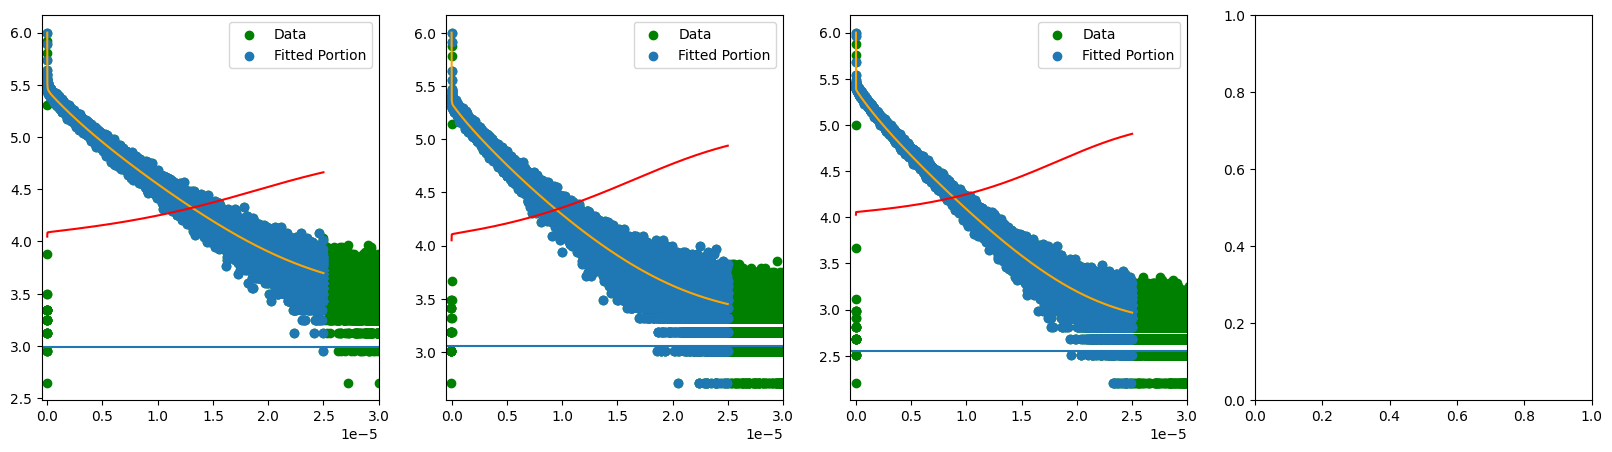

In [11]:
#fit1

fig, ax = plt.subplots(1,4, figsize = (20,5))
delay1 = 0 #delay in ns
id_start = np.argmax(trPLs.TRPLs_raw[:,0])+delay1
fit_stops = [25e-6, 25e-6, 25e-6, 25e-6]
selection_before = [0, 1, 2]


ratios1 = np.array(trPLs.powers)/trPLs.powers[0]
noises1 = []

for i, sPL in enumerate(selection_before):
    #PL = 300e-5
    id_series = sPL

    time_data1 = trPLs.ts[(trPLs.ts[:,id_series] < fit_stops[i]), id_series][id_start:]-trPLs.ts[id_start,id_series]
    trpl_data1 = trPLs.TRPLs_raw[(trPLs.ts[:,id_series] < fit_stops[i]), id_series][id_start:] + 1

    noise1 = np.average(1.2 + 1)
    zeros = trpl_data1 == 1

    r = np.amax(trPLs.TRPLs_raw[:, id_series][id_start:])/np.amax(trPLs.TRPLs_raw[:, id_series][:])
    print("r = "+str(np.sqrt(r)))
    ratios1[i] = ratios1[i]*np.sqrt(r)
    n_exp = 5
    previous_ps, pcov = scipy.optimize.curve_fit(fitfunc, time_data1, trpl_data1, maxfev = 1500000, p0 = [1]*(2*n_exp+1))
    multiexp_fit_data = fitfunc(time_data1, *previous_ps)
    weight = 1/multiexp_fit_data

    noise1 = noise1/np.amax(trpl_data1)
    trpl_data1 = trpl_data1/np.amax(trpl_data1)
    logdata1 = np.log10(1e6*trpl_data1)

    if(i == 0):
        times_data1 = time_data1
        trpls_data1 = trpl_data1
        logdatas1 = logdata1
        weights1 = weight
    
    else:
        times_data1 = np.append(times_data1, time_data1)
        trpls_data1 = np.append(trpls_data1, trpl_data1)
        logdatas1 = np.append(logdatas1, logdata1)
        weights1 = np.append(weights1, weight)

    ax[i].scatter(trPLs.ts[:, id_series]-trPLs.ts[id_start,id_series], np.log10(1e6*(trPLs.TRPLs_raw[:, id_series] + 1)/np.amax(trPLs.TRPLs_raw[id_start:, id_series] +1)), color = "green")
    ax[i].scatter(time_data1, (logdata1))
    ax[i].plot(time_data1, np.log10(1e6*multiexp_fit_data/np.amax(multiexp_fit_data)), color = 'orange')
    ax[i].axhline(np.log10(1e6*noise1))
    ax[i].set_xlim([-0.5e-6, 30e-6])
    
    ax[i].semilogy(time_data1, 4+np.sqrt(5*weight), color = 'red')
    ax[i].legend(['Data', 'Fitted Portion'])
    ax[i].set_yscale('linear')

    noises1.append(noise1)
    
print(ratios1)

r = 1.0
r = 1.0
r = 1.0
[ 1.          3.27200545 12.02124771 54.0236689 ]


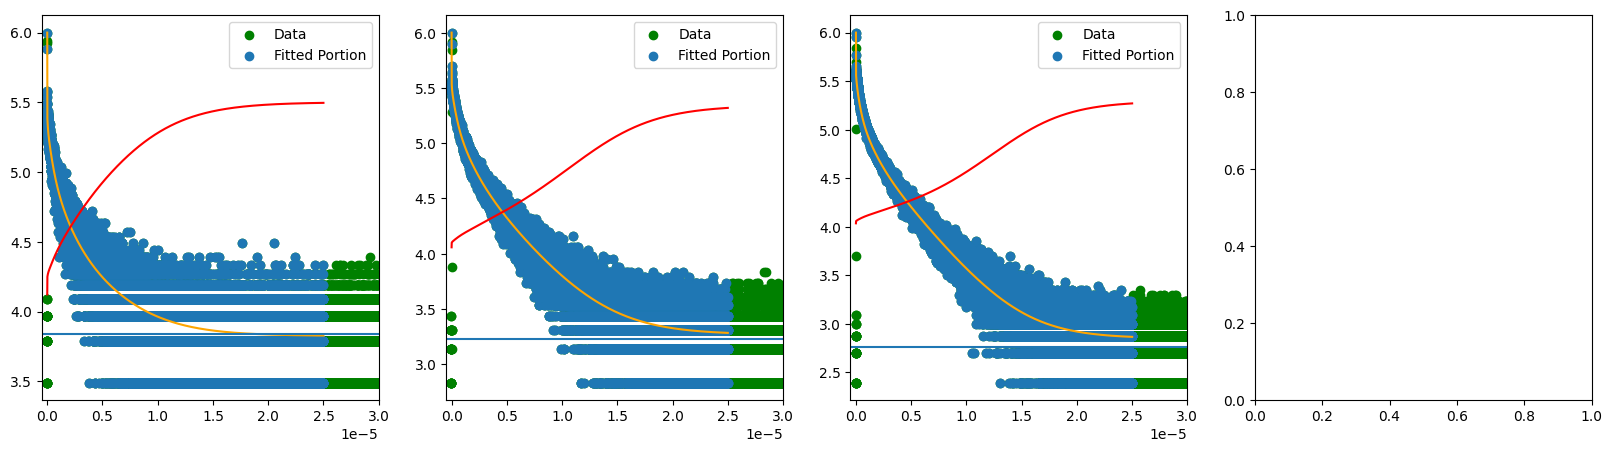

In [12]:
#fit1

fig, ax = plt.subplots(1,4, figsize = (20,5))
delay2 = 0 #delay in ns
id_start = np.argmax(trPLs_after.TRPLs_raw[:,0])+delay2
fit_stops = [25e-6, 25e-6, 25e-6, 25e-6]
selection_after = [0, 1, 2]

ratios2 = np.array(trPLs_after.powers)/trPLs_after.powers[0]
noises2 = []

for i, sPL in enumerate(selection_after):
    #PL = 300e-5
    id_series = sPL

    time_data2 = trPLs_after.ts[(trPLs_after.ts[:,id_series] < fit_stops[i]), id_series][id_start:]-trPLs_after.ts[id_start,id_series]
    trpl_data2 = trPLs_after.TRPLs_raw[(trPLs_after.ts[:,id_series] < fit_stops[i]), id_series][id_start:] + 1

    noise2 = np.average(trPLs_after.TRPLs_raw[-100:, id_series] + 1)
    zeros = trpl_data2 == 1

    r = np.amax(trPLs_after.TRPLs_raw[:, id_series][id_start:])/np.amax(trPLs_after.TRPLs_raw[:, id_series][:])
    print("r = "+str(np.sqrt(r)))
    ratios2[i] = ratios2[i]*np.sqrt(r)
    n_exp = 5
    previous_ps, pcov = scipy.optimize.curve_fit(fitfunc, time_data2, trpl_data2, maxfev = 1500000, p0 = [1]*(2*n_exp+1))
    multiexp_fit_data = fitfunc(time_data2, *previous_ps)
    weight = 1/multiexp_fit_data

    noise2 = noise2/np.amax(trpl_data2)
    trpl_data2 = trpl_data2/np.amax(trpl_data2)
    logdata2 = np.log10(1e6*trpl_data2)

    if(i == 0):
        times_data2 = time_data2
        trpls_data2 = trpl_data2
        logdatas2 = logdata2
        weights2 = weight
    
    else:
        times_data2 = np.append(times_data2, time_data2)
        trpls_data2 = np.append(trpls_data2, trpl_data2)
        logdatas2 = np.append(logdatas2, logdata2)
        weights2 = np.append(weights2, weight)

    ax[i].scatter(trPLs_after.ts[:, id_series]-trPLs_after.ts[id_start,id_series], np.log10(1e6*(trPLs_after.TRPLs_raw[:, id_series] + 1)/np.amax(trPLs_after.TRPLs_raw[id_start:, id_series] +1)), color = "green")
    ax[i].scatter(time_data2, (logdata2))
    ax[i].plot(time_data2, np.log10(1e6*multiexp_fit_data/np.amax(multiexp_fit_data)), color = 'orange')
    ax[i].axhline(np.log10(1e6*noise2))
    ax[i].set_xlim([-0.5e-6, 30e-6])
    
    ax[i].semilogy(time_data2, 4+np.sqrt(5*weight), color = 'red')
    ax[i].legend(['Data', 'Fitted Portion'])
    ax[i].set_yscale('linear')

    noises2.append(noise2)
    

#ratios2 = ratios2/ratios2[0]
print(ratios2)

In [13]:
params = []
a = 64348.30886337494 #From measurements with Manuel
true_values = {'N0':1e21, 'kdirect':1e-17, 
            'Bulk_tr1':1e24, 'Bulk_tr2':1e24, 'Bulk_tr3':1e24,
            'Bn1':1e-17, 'Bn2':1e-17, 'Bn3':1e-17, 
            'Bp1':1e-17, 'Bp2':1e-17, 'Bp3':1e-17, 
            'ETrap1':1.5, 'ETrap2':1.45, 'ETrap3':1.40, 
            'Eg':1.6, 'G': 1e29, 'Gfrac':1, 'Nc':2e24, 'Nv': 2e24, 'T': 300 }

kdirect = Fitparam(name = 'kdirect', val = 1e-17, lims = [1e-18, 1e-16], relRange = 0, range_type = 'log',
                lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'k$_2$',unit='m$^{3}$ s$^{-1}$')
params.append(kdirect)

Bulk_tr1 = Fitparam(name = 'Bulk_tr1', val =  true_values['Bulk_tr1'], lims = [1e19, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params.append(Bulk_tr1)
Bulk_tr2 = Fitparam(name = 'Bulk_tr2', val =  true_values['Bulk_tr2'], lims = [1e19, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params.append(Bulk_tr2)

Bn1 = Fitparam(name = 'Bn1', val = true_values['Bn1'], lims = [1e-20, 1e-10], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params.append(Bn1)
Bn2 = Fitparam(name = 'Bn2', val = true_values['Bn2'], lims = [1e-16, 1e-7], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params.append(Bn2)

Bp1 = Fitparam(name = 'Bp1', val = true_values['Bp1'], lims = [1e-20, 1e-10], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params.append(Bp1)
Bp2 = Fitparam(name = 'Bp2', val = true_values['Bp2'], lims = [1e-30, 1e-15], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params.append(Bp2)

ETrap1 = Fitparam(name = 'ETrap1', val = true_values['ETrap1'], lims = [0.2, trPLs.BG-0.2], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single1}$', unit='eV')
params.append(ETrap1)
ETrap2 = Fitparam(name = 'ETrap2', val = true_values['ETrap2'], lims = [trPLs.BG-0.4, trPLs.BG-0.001], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single2}$', unit='eV')
params.append(ETrap2)

N0_gen = Fitparam(name='N0_gen', val=N0s[0], lims = [1e13, 1e14], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params.append(N0_gen)

alpha = Fitparam(name='alpha', val=1e2*a, lims = [1e12, 1e13], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params.append(alpha)

L = Fitparam(name='L', val=450e-9, lims = [1e12, 1e13], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params.append(L)

N0 = Fitparam(name='N0', val=N0_gen.val/L.val, lims = [1e20, 1e21], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params.append(N0)

BG = Fitparam(name='Eg', val=trPLs.BG, relRange = 0, display_name='E$_g$', unit='eV$')
params.append(BG)

Nc = Fitparam(name='Nc', val=1e6*trPLs.Nc, relRange = 0, display_name='N$_c$', unit='m$^{-3}$')
params.append(Nc)

Nv = Fitparam(name='Nv', val=1e6*trPLs.Nv, relRange = 0, display_name='N$_v$', unit='m$^{-3}$')
params.append(Nv)

params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=1e+24, relRange=1, lims=[1e+19, 1e+25], std=0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=1e+24, relRange=1, lims=[1e+19, 1e+25], std=0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=1e-17, relRange=1, lims=[1e-20, 1e-10], std=0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn2, val=1e-17, relRange=1, lims=[1e-16, 1e-07], std=0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bp1, val=1e-17, relRange=1, lims=[1e-20, 1e-10], std=0, 

In [25]:
#Fit 1: Before
if 'mo_before' in locals():
    del mo_before

for i in range(1):
    print("-------------------------------------------------------------------Starting Fit: "+str(i)+"--------------------------------------------------------")
    X_dimension = ['t']
    y_dimension = 'PL [a.u.]'

    trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()

    if 'target' in locals():
        del target

    if 'mo_new' in locals():
        del mo_new

    target = {'model':partial(trPL_agent.TRPL_function, take_Log = True, Gs = np.array(trPLs.powers)/trPLs.powers[0], constant_floor_normalised_raw=noises1, reprates = trPLs.reprates_Hz, N_x = 20, equilibrate=True, nondimension = True), 'target_name':'trPL', 
              'data':{'X':times_data1, 'y':logdatas1, 'X_dimensions':X_dimension, 'X_units':'s', 'y_dimension':y_dimension, 'y_unit':''}, 'weight': 1, 'target_weight':1}

    mo_new = MooBOtorch(targets = [target], params = params, res_dir=res_dir, parallel=False, verbose=True)
    obj_type="MSE" #MLE_trPL_MS"#'MSE'#'hausdorff'
    loss= 'linear' #'soft_l1' #It takes the sqrt(MSE)
    threshold=0.5#50

    kwargs_posterior = {'Nres':10,'Ninteg':1e3,'logscale':True,'vmin':1e-100,'zoom':0,'min_prob':1e-40,'clear_axis':False,'True_values':true_values,'show_points':True,'savefig':False,'full_grid':True,'randomize':True}

    ax_client = mo_new.BoTorchOpti(n_jobs = [4,4], n_step_points = [150, 200], models = ['Sobol','GPEI'], obj_type = obj_type, loss = loss, threshold = threshold,use_CUDA=False,is_MOO = False, verbose = True, show_posterior = False, kwargs_posterior = kwargs_posterior)
    
    import pickle
    with open('./250520-results_BOs-FAPIBefore-N0Fixed-kradFixed-OneDeepOneShalowTrap-powersratios-150200times-'+str(0)+'.pickle', 'wb') as handle:
        pickle.dump(mo_new, handle, protocol=pickle.HIGHEST_PROTOCOL)

[INFO 05-21 18:08:22] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-21 18:08:22] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='Bulk_tr1', parameter_type=FLOAT, range=[19.0, 25.0]), RangeParameter(name='Bulk_tr2', parameter_type=FLOAT, range=[19.0, 25.0]), RangeParameter(name='Bn1', parameter_type=FLOAT, range=[-20.0, -10.0]), RangeParameter(name='Bn2', parameter_type=FLOAT, range=[-16.0, -7.0]), RangeParameter(name='Bp1', parameter_type=FLOAT, range=[-20.0, -10.0]), RangeParameter(name='Bp2', parameter_type=FLOAT, range=[-30.0, -15.0]), RangeParameter(name='ETrap1', parameter_type=FLOAT, range=[0.2, 1.353]), RangeParameter(name='ETrap2', parameter_type=FLOAT, range=[1.153, 1.552])], parameter_constraints=[]).
[INFO 05-21 18:08:22] ax.service.ax_client: Generated new trial 

-------------------------------------------------------------------Starting Fit: 0--------------------------------------------------------


[INFO 05-21 18:08:55] ax.service.ax_client: Completed trial 0 with data: {'MSE': (2.133731, None)}.
[INFO 05-21 18:08:55] ax.service.ax_client: Completed trial 1 with data: {'MSE': (3.226244, None)}.
[INFO 05-21 18:08:55] ax.service.ax_client: Completed trial 2 with data: {'MSE': (2.479109, None)}.
[INFO 05-21 18:08:55] ax.service.ax_client: Completed trial 3 with data: {'MSE': (2.141805, None)}.
[INFO 05-21 18:08:55] ax.service.ax_client: Generated new trial 4 with parameters {'Bulk_tr1': 24.993091, 'Bulk_tr2': 23.428898, 'Bn1': -17.444418, 'Bn2': -9.186828, 'Bp1': -14.462124, 'Bp2': -19.154975, 'ETrap1': 1.152442, 'ETrap2': 1.361984} using model Sobol.
[INFO 05-21 18:08:55] ax.service.ax_client: Generated new trial 5 with parameters {'Bulk_tr1': 19.055545, 'Bulk_tr2': 21.326282, 'Bn1': -13.262954, 'Bn2': -14.02122, 'Bp1': -15.393612, 'Bp2': -27.026234, 'ETrap1': 0.705504, 'ETrap2': 1.282381} using model Sobol.
[INFO 05-21 18:08:55] ax.service.ax_client: Generated new trial 6 with par

Sovle time was too long: 1317.8257156470027


[INFO 05-21 18:44:41] ax.service.ax_client: Completed trial 24 with data: {'MSE': (1.661276, None)}.
[INFO 05-21 18:44:41] ax.service.ax_client: Completed trial 25 with data: {'MSE': (1.992594, None)}.
[INFO 05-21 18:44:41] ax.service.ax_client: Completed trial 26 with data: {'MSE': (1.846652, None)}.
[INFO 05-21 18:44:41] ax.service.ax_client: Completed trial 27 with data: {'MSE': (2.141803, None)}.
[INFO 05-21 18:44:41] ax.service.ax_client: Generated new trial 28 with parameters {'Bulk_tr1': 23.998185, 'Bulk_tr2': 22.666926, 'Bn1': -13.640844, 'Bn2': -13.515183, 'Bp1': -18.749714, 'Bp2': -29.276748, 'ETrap1': 0.387956, 'ETrap2': 1.405167} using model Sobol.
[INFO 05-21 18:44:41] ax.service.ax_client: Generated new trial 29 with parameters {'Bulk_tr1': 19.953222, 'Bulk_tr2': 20.588145, 'Bn1': -16.882176, 'Bn2': -9.279537, 'Bp1': -11.556314, 'Bp2': -22.060123, 'ETrap1': 0.826035, 'ETrap2': 1.335147} using model Sobol.
[INFO 05-21 18:44:41] ax.service.ax_client: Generated new trial 30 

Sovle time was too long: 772.5641846550025


[INFO 05-21 19:33:04] ax.service.ax_client: Generated new trial 113 with parameters {'Bulk_tr1': 20.911988, 'Bulk_tr2': 21.061065, 'Bn1': -15.398487, 'Bn2': -14.60007, 'Bp1': -13.310375, 'Bp2': -23.310296, 'ETrap1': 1.197197, 'ETrap2': 1.422424} using model Sobol.
[INFO 05-21 19:33:04] ax.service.ax_client: Generated new trial 114 with parameters {'Bulk_tr1': 20.139068, 'Bulk_tr2': 24.330265, 'Bn1': -12.435752, 'Bn2': -9.641701, 'Bp1': -11.235814, 'Bp2': -26.812639, 'ETrap1': 0.318745, 'ETrap2': 1.486483} using model Sobol.
[INFO 05-21 19:33:05] ax.service.ax_client: Generated new trial 115 with parameters {'Bulk_tr1': 23.815269, 'Bulk_tr2': 20.426289, 'Bn1': -18.252156, 'Bn2': -13.279957, 'Bp1': -19.044553, 'Bp2': -18.884585, 'ETrap1': 1.033674, 'ETrap2': 1.154375} using model Sobol.


Sovle time was too long: 633.5613984050033


[INFO 05-21 19:43:56] ax.service.ax_client: Completed trial 112 with data: {'MSE': (2.081308, None)}.
[INFO 05-21 19:43:56] ax.service.ax_client: Completed trial 113 with data: {'MSE': (0.495301, None)}.
[INFO 05-21 19:43:56] ax.service.ax_client: Completed trial 114 with data: {'MSE': (1.846652, None)}.
[INFO 05-21 19:43:56] ax.service.ax_client: Completed trial 115 with data: {'MSE': (0.124742, None)}.
[INFO 05-21 19:43:56] ax.service.ax_client: Generated new trial 116 with parameters {'Bulk_tr1': 24.475678, 'Bulk_tr2': 23.754683, 'Bn1': -16.744729, 'Bn2': -11.605068, 'Bp1': -18.070482, 'Bp2': -17.861107, 'ETrap1': 0.467239, 'ETrap2': 1.546123} using model Sobol.
[INFO 05-21 19:43:57] ax.service.ax_client: Generated new trial 117 with parameters {'Bulk_tr1': 19.475638, 'Bulk_tr2': 19.502031, 'Bn1': -12.566207, 'Bn2': -11.340714, 'Bp1': -12.136819, 'Bp2': -25.957583, 'ETrap1': 0.884901, 'ETrap2': 1.217182} using model Sobol.
[INFO 05-21 19:43:57] ax.service.ax_client: Generated new tr

Sovle time was too long: 609.5904786329993


[INFO 05-21 20:44:26] ax.service.ax_client: Generated new trial 230 with parameters {'Bulk_tr1': 23.472242, 'Bulk_tr2': 22.061864, 'Bn1': -20.0, 'Bn2': -16.0, 'Bp1': -18.105032, 'Bp2': -30.0, 'ETrap1': 1.353, 'ETrap2': 1.153} using model GPEI.
[INFO 05-21 20:44:55] ax.service.ax_client: Generated new trial 231 with parameters {'Bulk_tr1': 23.842012, 'Bulk_tr2': 22.399287, 'Bn1': -20.0, 'Bn2': -16.0, 'Bp1': -19.094503, 'Bp2': -15.0, 'ETrap1': 1.353, 'ETrap2': 1.153} using model GPEI.
[INFO 05-21 20:45:22] ax.service.ax_client: Generated new trial 232 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 21.46322, 'Bn1': -15.382263, 'Bn2': -16.0, 'Bp1': -20.0, 'Bp2': -30.0, 'ETrap1': 0.2, 'ETrap2': 1.473617} using model GPEI.
[INFO 05-21 20:46:05] ax.service.ax_client: Generated new trial 233 with parameters {'Bulk_tr1': 20.17188, 'Bulk_tr2': 25.0, 'Bn1': -20.0, 'Bn2': -16.0, 'Bp1': -20.0, 'Bp2': -30.0, 'ETrap1': 0.2, 'ETrap2': 1.268781} using model GPEI.
[INFO 05-21 20:47:07] ax.service.ax_cli

Sovle time was too long: 622.0413276559993


[INFO 05-21 22:35:47] ax.service.ax_client: Completed trial 310 with data: {'MSE': (0.237196, None)}.
[INFO 05-21 22:35:47] ax.service.ax_client: Completed trial 311 with data: {'MSE': (0.189127, None)}.
[INFO 05-21 22:35:47] ax.service.ax_client: Completed trial 312 with data: {'MSE': (1.696216, None)}.
[INFO 05-21 22:35:47] ax.service.ax_client: Completed trial 313 with data: {'MSE': (0.334403, None)}.
[INFO 05-21 22:36:25] ax.service.ax_client: Generated new trial 314 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 25.0, 'Bn1': -12.967956, 'Bn2': -7.0, 'Bp1': -13.855918, 'Bp2': -15.0, 'ETrap1': 0.776349, 'ETrap2': 1.552} using model GPEI.
[INFO 05-21 22:37:11] ax.service.ax_client: Generated new trial 315 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 21.688139, 'Bn1': -18.646445, 'Bn2': -7.0, 'Bp1': -20.0, 'Bp2': -15.0, 'ETrap1': 1.353, 'ETrap2': 1.475395} using model GPEI.
[INFO 05-21 22:38:18] ax.service.ax_client: Generated new trial 316 with parameters {'Bulk_tr1': 19.0, 'Bulk_t

Sovle time was too long: 9772.568245692994


[INFO 05-22 02:38:13] ax.service.ax_client: Completed trial 378 with data: {'MSE': (2.141783, None)}.
[INFO 05-22 02:38:13] ax.service.ax_client: Completed trial 379 with data: {'MSE': (1.846652, None)}.
[INFO 05-22 02:38:13] ax.service.ax_client: Completed trial 380 with data: {'MSE': (0.545575, None)}.
[INFO 05-22 02:38:13] ax.service.ax_client: Completed trial 381 with data: {'MSE': (1.023679, None)}.
[INFO 05-22 02:39:13] ax.service.ax_client: Generated new trial 382 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 23.436738, 'Bn1': -10.0, 'Bn2': -16.0, 'Bp1': -18.593829, 'Bp2': -15.0, 'ETrap1': 0.2, 'ETrap2': 1.294138} using model GPEI.
[INFO 05-22 02:40:24] ax.service.ax_client: Generated new trial 383 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 24.311, 'Bn1': -10.0, 'Bn2': -10.337323, 'Bp1': -20.0, 'Bp2': -30.0, 'ETrap1': 0.2, 'ETrap2': 1.280552} using model GPEI.
[INFO 05-22 02:41:43] ax.service.ax_client: Generated new trial 384 with parameters {'Bulk_tr1': 20.112948, 'Bulk_t

Sovle time was too long: 718.8224587779987


[INFO 05-22 03:00:19] ax.service.ax_client: Completed trial 386 with data: {'MSE': (1.846652, None)}.
[INFO 05-22 03:00:19] ax.service.ax_client: Completed trial 387 with data: {'MSE': (0.355244, None)}.
[INFO 05-22 03:00:19] ax.service.ax_client: Completed trial 388 with data: {'MSE': (0.191809, None)}.
[INFO 05-22 03:00:19] ax.service.ax_client: Completed trial 389 with data: {'MSE': (0.3185, None)}.
[INFO 05-22 03:01:17] ax.service.ax_client: Generated new trial 390 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 25.0, 'Bn1': -10.784468, 'Bn2': -16.0, 'Bp1': -20.0, 'Bp2': -30.0, 'ETrap1': 1.353, 'ETrap2': 1.350187} using model GPEI.
[INFO 05-22 03:02:33] ax.service.ax_client: Generated new trial 391 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 24.221431, 'Bn1': -20.0, 'Bn2': -16.0, 'Bp1': -10.0, 'Bp2': -30.0, 'ETrap1': 1.353, 'ETrap2': 1.552} using model GPEI.
[INFO 05-22 03:03:42] ax.service.ax_client: Generated new trial 392 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'B

Sovle time was too long: 3280.8581279810023


[INFO 05-22 04:27:23] ax.service.ax_client: Completed trial 406 with data: {'MSE': (0.588965, None)}.
[INFO 05-22 04:27:23] ax.service.ax_client: Completed trial 407 with data: {'MSE': (0.338626, None)}.
[INFO 05-22 04:27:23] ax.service.ax_client: Completed trial 408 with data: {'MSE': (1.846652, None)}.
[INFO 05-22 04:27:23] ax.service.ax_client: Completed trial 409 with data: {'MSE': (0.342522, None)}.
[INFO 05-22 04:28:25] ax.service.ax_client: Generated new trial 410 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 21.485377, 'Bn1': -20.0, 'Bn2': -16.0, 'Bp1': -10.0, 'Bp2': -19.647872, 'ETrap1': 1.353, 'ETrap2': 1.481697} using model GPEI.
[INFO 05-22 04:29:22] ax.service.ax_client: Generated new trial 411 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 19.0, 'Bn1': -20.0, 'Bn2': -16.0, 'Bp1': -10.0, 'Bp2': -15.0, 'ETrap1': 1.353, 'ETrap2': 1.420397} using model GPEI.
[INFO 05-22 04:30:53] ax.service.ax_client: Generated new trial 412 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 20.

Sovle time was too long: 2751.464490282


[INFO 05-22 05:32:03] ax.service.ax_client: Completed trial 418 with data: {'MSE': (0.644592, None)}.
[INFO 05-22 05:32:03] ax.service.ax_client: Completed trial 419 with data: {'MSE': (0.336129, None)}.
[INFO 05-22 05:32:03] ax.service.ax_client: Completed trial 420 with data: {'MSE': (1.846652, None)}.
[INFO 05-22 05:32:03] ax.service.ax_client: Completed trial 421 with data: {'MSE': (0.438969, None)}.
[INFO 05-22 05:33:21] ax.service.ax_client: Generated new trial 422 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 25.0, 'Bn1': -10.0, 'Bn2': -7.0, 'Bp1': -19.173811, 'Bp2': -30.0, 'ETrap1': 1.353, 'ETrap2': 1.256776} using model GPEI.
[INFO 05-22 05:34:53] ax.service.ax_client: Generated new trial 423 with parameters {'Bulk_tr1': 19.189116, 'Bulk_tr2': 24.624334, 'Bn1': -10.903496, 'Bn2': -7.0, 'Bp1': -20.0, 'Bp2': -30.0, 'ETrap1': 1.353, 'ETrap2': 1.310541} using model GPEI.
[INFO 05-22 05:36:13] ax.service.ax_client: Generated new trial 424 with parameters {'Bulk_tr1': 25.0, 'Bulk_t

In [14]:
import pickle
with open(r'./FittingResults/250520-results_BOs-FAPIBefore-N0Fixed-kradFixed-OneDeepOneShalowTrap-powersratios-150200times-0.pickle', 'rb') as f:
    mo_new = pickle.load(f)

MSE = 0.014229416774073104


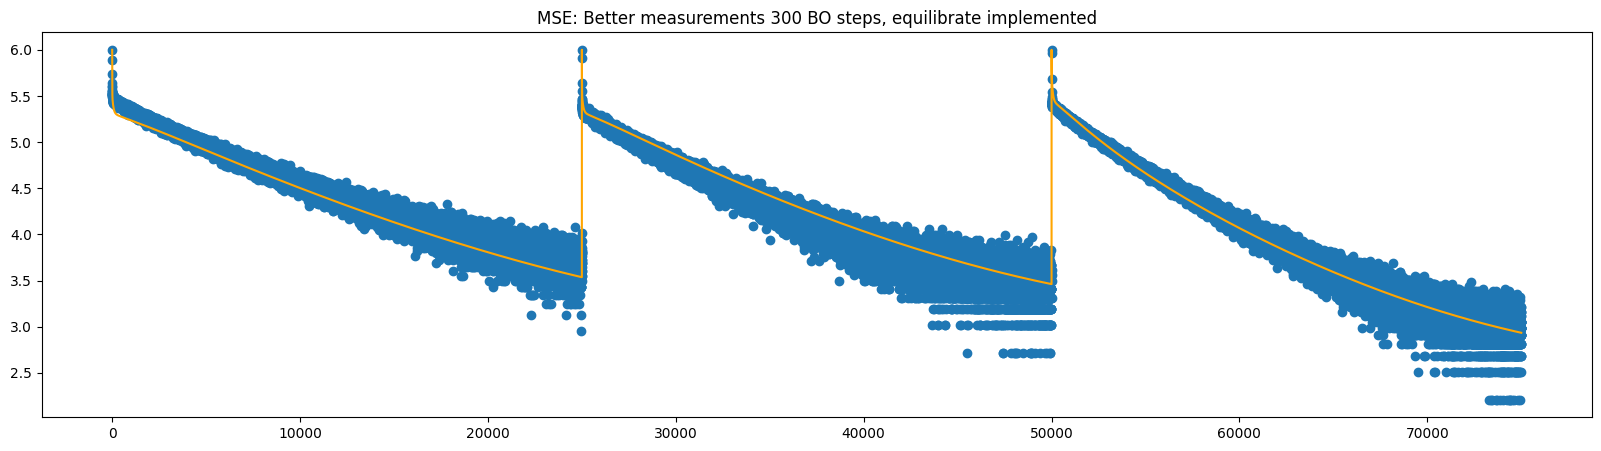

In [95]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()
output_after = trPL_agent.TRPL_function(times_data1, gradient_mo46.params, take_Log = True, Gs = np.array(trPLs.powers)/trPLs.powers[0], constant_floor_normalised_raw=noises1, reprates = trPLs.reprates_Hz, N_x = 20, equilibrate=True, nondimension=True)

plt.scatter(np.arange(len(times_data1)), logdatas1)
plt.plot(np.arange(len(times_data1)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")

print("MSE = "+str(np.mean(np.square((logdatas1 - output_after)))))

MSE = 0.014229416774073104


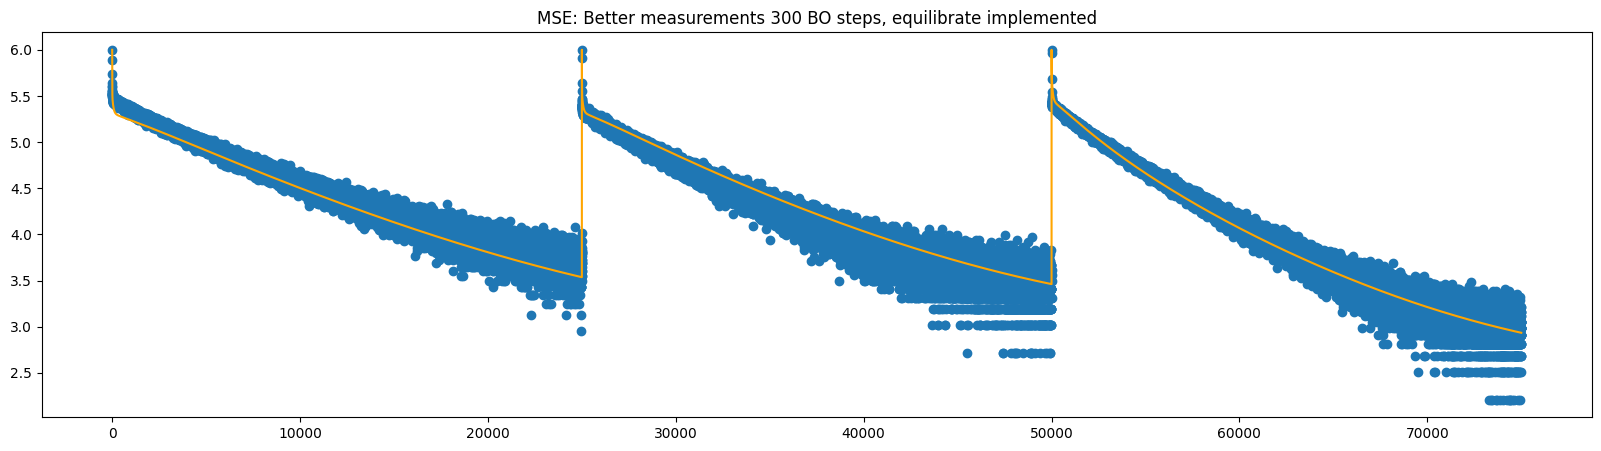

In [27]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()
output_after = trPL_agent.TRPL_function(times_data1, gradient_mo46.params, take_Log = True, Gs = np.array(trPLs.powers)/trPLs.powers[0], constant_floor_normalised_raw=noises1, reprates = trPLs.reprates_Hz, N_x = 20, equilibrate=True, nondimension=True)

plt.scatter(np.arange(len(times_data1)), logdatas1)
plt.plot(np.arange(len(times_data1)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")

print("MSE = "+str(np.mean(np.square((logdatas1 - output_after)))))

In [15]:
gradient_mo46 = deepcopy(mo_new) # get the best parameters

for p, pBO in zip(gradient_mo46.params,mo_new.params):
    p.val = pBO.val
    p.startVal = pBO.val # reset the start values to the best ones before starting the gradient descent

    if(p.name == 'N0_gen'):
        p.relRange = 1

    if(p.name == 'kdirect'):
        p.relRange = 1

    # if(p.name == 'ETrap1'):
    #     p.lims = [0.1, 1.599]

kwargs_curve =  {'ftol':1e-11, 'xtol':1e-11, 'gtol': 1e-11, 'diff_step':0.00001,'loss':'linear','maxfev':100000}

print('Start curve fit')
try:
    rc = gradient_mo46.optimize_curvefit(kwargs=kwargs_curve) # fit the best parameters to the data
except Exception as e:
    print(e)
    print('Curve fit did not find a better solution')

Start curve fit
[np.float64(-17.0), np.float64(23.39072243786093), np.float64(21.782329824731995), np.float64(-14.35522352489983), np.float64(-15.779835939419), np.float64(-18.320225793413165), np.float64(-29.772096785718716), np.float64(0.3439948833131241), np.float64(1.366060674978547), np.float64(13.797305354896)]
lb = [np.float64(-18.0), np.float64(19.0), np.float64(19.0), np.float64(-20.0), np.float64(-16.0), np.float64(-20.0), np.float64(-30.0), np.float64(0.2), np.float64(1.153), np.float64(13.0)][np.float64(-16.0), np.float64(25.0), np.float64(25.0), np.float64(-10.0), np.float64(-7.0), np.float64(-10.0), np.float64(-15.0), np.float64(1.353), np.float64(1.552), np.float64(14.0)]


In [30]:
with open(r'./250526-Gradient-optimisedBefore_N0GenKrad.pickle', 'wb') as handle:
        pickle.dump(mo_new, handle, protocol=pickle.HIGHEST_PROTOCOL)

MSE = 0.019911483493800126


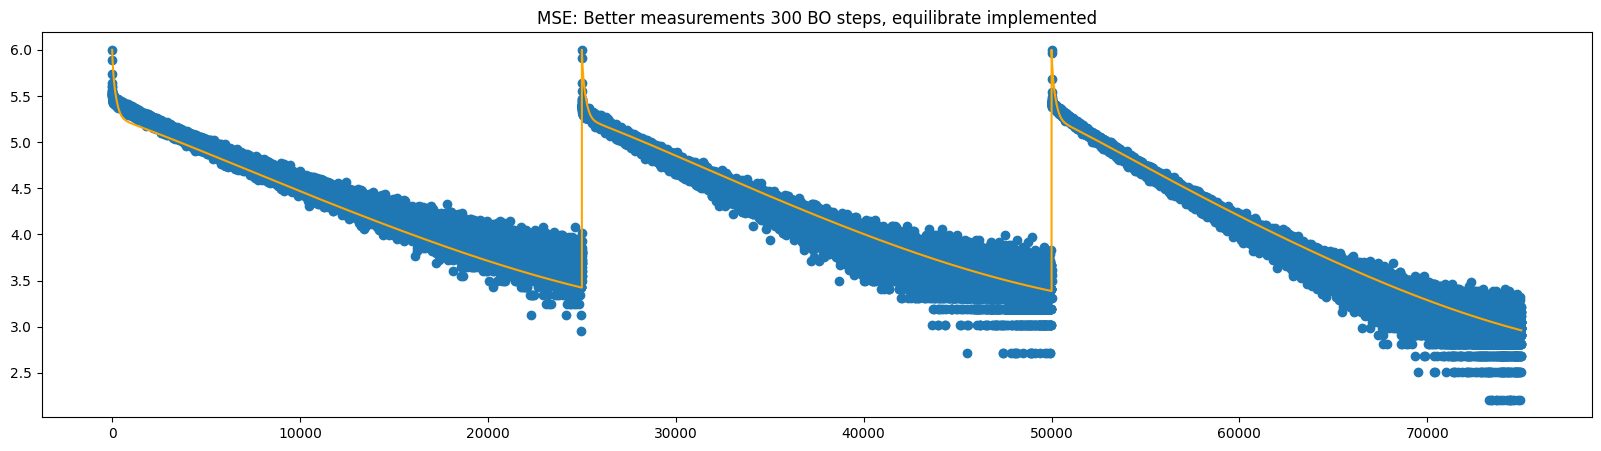

In [33]:
fig, ax = plt.subplots(1,1, figsize = (20,5))

trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()

output_before = trPL_agent.TRPL_function(times_data1, gradient_mo4.params, take_Log = True, Gs = np.array(trPLs.powers)/trPLs.powers[0], constant_floor_normalised_raw=noises1, reprates = trPLs.reprates_Hz, N_x = 20, equilibrate=True, nondimension=True)

plt.scatter(np.arange(len(times_data1)), logdatas1)
plt.plot(np.arange(len(times_data1)), output_before, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")

print("MSE = "+str(np.mean(np.square((logdatas1 - output_before)))))

MSE = 0.014229416774073104


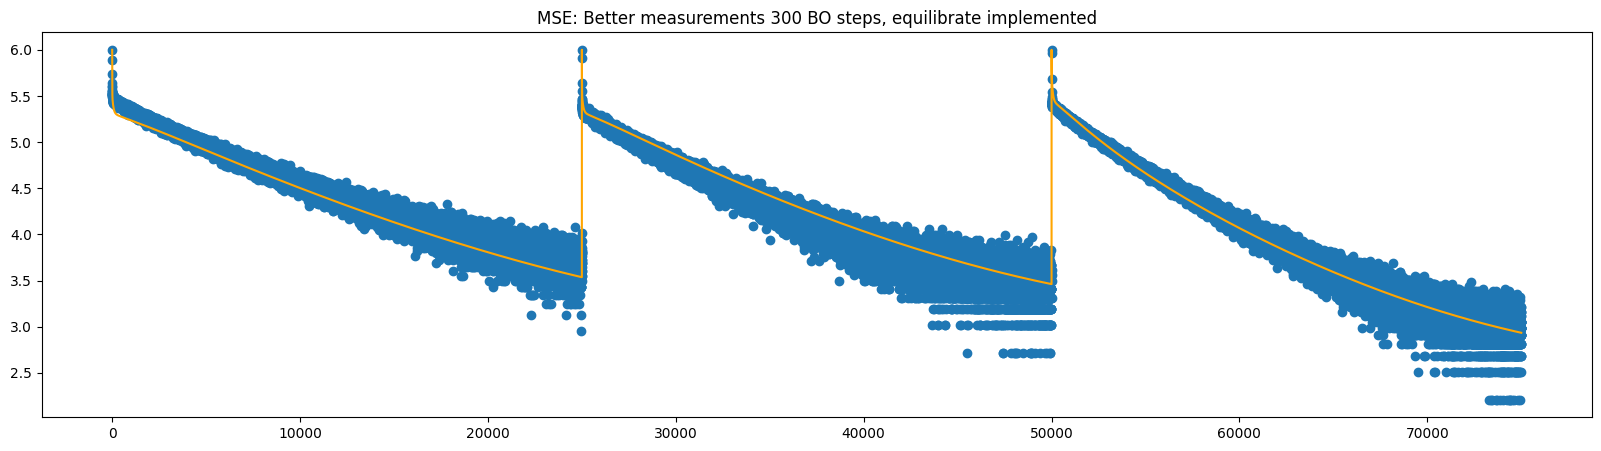

In [60]:
fig, ax = plt.subplots(1,1, figsize = (20,5))

trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()

output_before = trPL_agent.TRPL_function(times_data1, gradient_mo46.params, take_Log = True, Gs = np.array(trPLs.powers)/trPLs.powers[0], constant_floor_normalised_raw=noises1, reprates = trPLs.reprates_Hz, N_x = 20, equilibrate=True, nondimension=True)

plt.scatter(np.arange(len(times_data1)), logdatas1)
plt.plot(np.arange(len(times_data1)), output_before, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")

print("MSE = "+str(np.mean(np.square((logdatas1 - output_before)))))

In [59]:
gradient_mo46.params

[Fitparam(name=kdirect, val=1.969782507644605e-17, relRange=1, lims=[1e-18, 1e-16], std=1.0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=1.1855005474647105e+23, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=1.3651312249108357e+21, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=4.241814891012085e-15, relRange=1, lims=[1e-20, 1e-10], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn2, val=1.7259123921493207e-13, relRange=1, lims=[1e-16, 1e-07], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type

In [57]:
import pickle
with open(r'./250526-Gradient-optimisedBefore_N0GenKrad.pickle', 'wb') as handle:
        pickle.dump(gradient_mo46, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
import pickle
with open(r'/media/qrb/0726-A615/Computer2CONTENTS/Simulations-Chapter1-Bis/LPtrPLFAPI/250416-Gradient-optimisedBefore.pickle', 'rb') as f:
    gradient_mo4 = pickle.load(f)

In [35]:
gradient_mo5 = deepcopy(gradient_mo4) # get the best parameters

for p, pBO in zip(gradient_mo5.params,gradient_mo4.params):
    p.val = pBO.val
    p.startVal = pBO.val # reset the start values to the best ones before starting the gradient descent

    if(p.name == 'N0_gen'):
        p.relRange = 1

    if(p.name == 'kdirect'):
        p.relRange = 1

    else:
        p.relRange = 0

kwargs_curve =  {'ftol':1e-11, 'xtol':1e-11, 'gtol': 1e-11, 'diff_step':0.00001,'loss':'linear','maxfev':100000}

print('Start curve fit')
try:
    rc = gradient_mo5.optimize_curvefit(kwargs=kwargs_curve) # fit the best parameters to the data
except Exception as e:
    print(e)
    print('Curve fit did not find a better solution')

Start curve fit
[np.float64(-17.0)]
lb = [np.float64(-18.0)][np.float64(-16.0)]


MSE = 0.018957359919102135


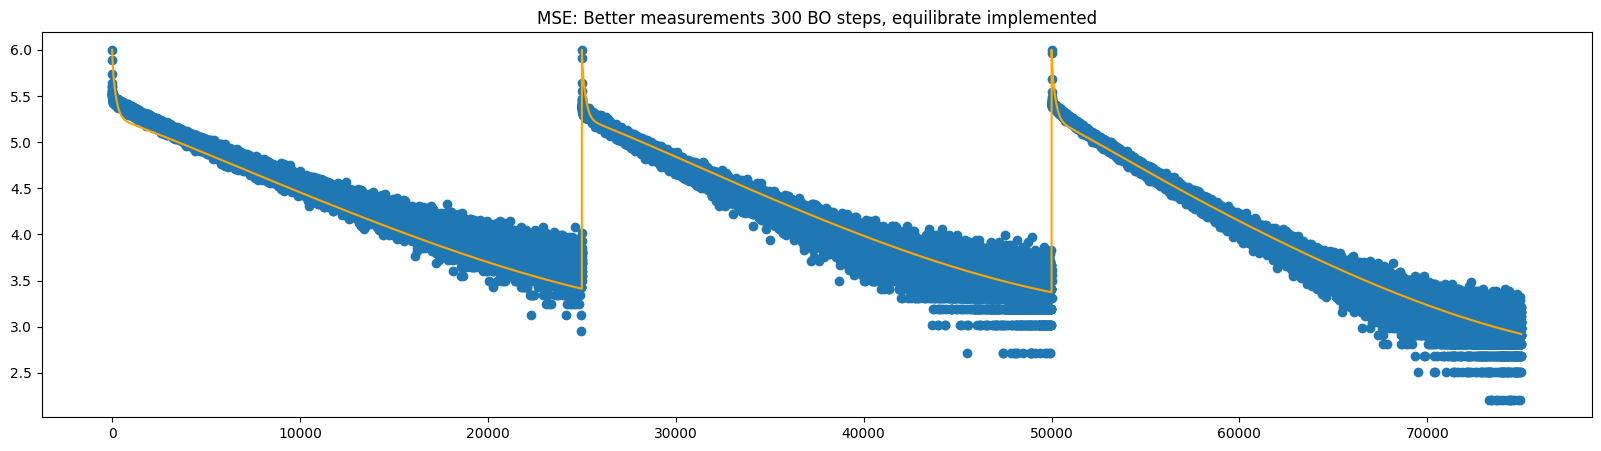

In [37]:
fig, ax = plt.subplots(1,1, figsize = (20,5))

output_after = trPL_agent.TRPL_function(times_data1, gradient_mo5.params, take_Log = True, Gs = np.array(trPLs.powers)/trPLs.powers[0], constant_floor_normalised_raw=noises1, reprates = trPLs.reprates_Hz, N_x = 20, equilibrate=True, nondimension=True)

plt.scatter(np.arange(len(times_data1)), logdatas1)
plt.plot(np.arange(len(times_data1)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")

print("MSE = "+str(np.mean(np.square((logdatas1 - output_after)))))

# Fitting of the second mesurements, keeping the first traps fixed.

In [21]:
with open(r'./250523-Gradient-optimisedBefore_N0GenKrad.pickle', 'rb') as f:
    gradient_mo46 = pickle.load(f)

EOFError: Ran out of input

In [47]:
params_after = []
a = 64348.30886337494 #From measurements with Manuel

true_values = {'N0':1e21, 'kdirect':1e-17, 
            'Bulk_tr1':1e24, 'Bulk_tr2':1e24, 'Bulk_tr3':1e24,
            'Bn1':1e-17, 'Bn2':1e-17, 'Bn3':1e-17, 
            'Bp1':1e-17, 'Bp2':1e-17, 'Bp3':1e-17, 
            'ETrap1':1.5, 'ETrap2':1.45, 'ETrap3':1.40, 
            'Eg':1.6, 'G': 1e29, 'Gfrac':1, 'Nc':2e24, 'Nv': 2e24, 'T': 300 }

kdirect = Fitparam(name = 'kdirect', val = 1e-17, lims = [1e-18, 1e-16], relRange = 0, range_type = 'log',
                lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'k$_2$',unit='m$^{3}$ s$^{-1}$')
params_after.append(kdirect)

Bulk_tr1 = Fitparam(name = 'Bulk_tr1', val =  true_values['Bulk_tr1'], lims = [1e18, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params_after.append(Bulk_tr1)
Bulk_tr2 = Fitparam(name = 'Bulk_tr2', val =  true_values['Bulk_tr2'], lims = [1e18, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params_after.append(Bulk_tr2)
Bulk_tr3 = Fitparam(name = 'Bulk_tr3', val =  true_values['Bulk_tr3'], lims = [1e18, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params_after.append(Bulk_tr3)

Bn1 = Fitparam(name = 'Bn1', val = true_values['Bn1'], lims = [1e-20, 1e-10], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params_after.append(Bn1)
Bn2 = Fitparam(name = 'Bn2', val = true_values['Bn2'], lims = [1e-16, 1e-6], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params_after.append(Bn2)
Bn3 = Fitparam(name = 'Bn3', val = 1e-12, lims = [1e-16, 1e-6], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params_after.append(Bn3)

Bp1 = Fitparam(name = 'Bp1', val = true_values['Bp1'], lims = [1e-20, 1e-10], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params_after.append(Bp1)
Bp2 = Fitparam(name = 'Bp2', val = true_values['Bp2'], lims = [1e-30, 1e-15], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params_after.append(Bp2)
Bp3 = Fitparam(name = 'Bp3', val = 1e-20, lims = [1e-20, 1e-10], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params_after.append(Bp3)

ETrap1 = Fitparam(name = 'ETrap1', val = true_values['ETrap1'], lims = [0.2, trPLs_after.BG-0.2], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single1}$', unit='eV')
params_after.append(ETrap1)
ETrap2 = Fitparam(name = 'ETrap2', val = true_values['ETrap2'], lims = [trPLs_after.BG-0.4, trPLs_after.BG-0.001], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single2}$', unit='eV')
params_after.append(ETrap2)
ETrap3 = Fitparam(name = 'ETrap3', val = 1.4, lims =[trPLs_after.BG-0.4, trPLs_after.BG-0.001], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single3}$', unit='eV')
params_after.append(ETrap3)

N0_gen = Fitparam(name='N0_gen', val=N0s_after[0]*gradient_mo46.params[9].val/N0s[0], lims = [1e13, 1e14], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_after.append(N0_gen)

alpha = Fitparam(name='alpha', val=1e2*a, lims = [1e12, 1e13], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_after.append(alpha)

L = Fitparam(name='L', val=450e-9, lims = [1e12, 1e13], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_after.append(L)

N0 = Fitparam(name='N0', val=N0_gen.val/L.val, lims = [1e20, 1e21], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_after.append(N0)

BG = Fitparam(name='Eg', val=trPLs_after.BG, relRange = 0, display_name='E$_g$', unit='eV$')
params_after.append(BG)

Nc = Fitparam(name='Nc', val=1e6*trPLs_after.Nc, relRange = 0, display_name='N$_c$', unit='m$^{-3}$')
params_after.append(Nc)

Nv = Fitparam(name='Nv', val=1e6*trPLs_after.Nv, relRange = 0, display_name='N$_v$', unit='m$^{-3}$')
params_after.append(Nv)


In [49]:
# New params for after condition

#params_newAfter = deepcopy(gradient_mo4) # get the best parameters
for p in params_after:
    for pBO in gradient_mo46.params:
        if (p.name == pBO.name and not(p.name == 'N0_gen')):
            print(p.name, pBO.name)
            p.val = pBO.val
            p.startVal = pBO.val # reset the start values to the best ones before starting the gradient descent
            p.relRange = 0
            


kdirect kdirect
Bulk_tr1 Bulk_tr1
Bulk_tr2 Bulk_tr2
Bn1 Bn1
Bn2 Bn2
Bp1 Bp1
Bp2 Bp2
ETrap1 ETrap1
ETrap2 ETrap2
alpha alpha
L L
N0 N0
Eg Eg
Nc Nc
Nv Nv


In [50]:
params_after

[Fitparam(name=kdirect, val=1.969782507644605e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=1.1855005474647105e+23, relRange=0, lims=[1e+18, 1e+25], std=0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=1.3651312249108357e+21, relRange=0, lims=[1e+18, 1e+25], std=0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=1e+24, relRange=1, lims=[1e+18, 1e+25], std=0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=4.241814891012085e-15, relRange=0, lims=[1e-20, 1e-10], std=0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitp

In [98]:
gradient_mo4.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=3.882422787054201e+21, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=2.7534659237324936e+21, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=1.1997419828095108e-16, relRange=1, lims=[1e-20, 1e-10], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn2, val=4.4432655745958114e-07, relRange=1, lims=[1e-16, 1e-06], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=lo

In [51]:
#Fit 1: Before
if 'mo_before' in locals():
    del mo_before

for i in range(1):
    print("-------------------------------------------------------------------Starting Fit: "+str(i)+"--------------------------------------------------------")
    X_dimension = ['t']
    y_dimension = 'PL [a.u.]'

    trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()

    if 'target' in locals():
        del target

    if 'mo_newAfter' in locals():
        del mo_newAfter

    target = {'model':partial(trPL_agent.TRPL_function, take_Log = True, Gs = np.array(trPLs_after.powers)/trPLs_after.powers[0], constant_floor_normalised_raw=noises2, reprates = trPLs_after.reprates_Hz, N_x = 20, equilibrate=True, nondimension = True), 'target_name':'trPL', 
              'data':{'X':times_data2, 'y':logdatas2, 'X_dimensions':X_dimension, 'X_units':'s', 'y_dimension':y_dimension, 'y_unit':''}, 'weight': 1, 'target_weight':1}

    mo_newAfter = MooBOtorch(targets = [target], params = params_after, res_dir=res_dir, parallel=False, verbose=True)
    obj_type="MSE" #MLE_trPL_MS"#'MSE'#'hausdorff'
    loss= 'linear' #'soft_l1' #It takes the sqrt(MSE)
    threshold=0.5#50

    kwargs_posterior = {'Nres':10,'Ninteg':1e3,'logscale':True,'vmin':1e-100,'zoom':0,'min_prob':1e-40,'clear_axis':False,'True_values':true_values,'show_points':True,'savefig':False,'full_grid':True,'randomize':True}

    ax_client = mo_newAfter.BoTorchOpti(n_jobs = [4,4], n_step_points = [150, 250], models = ['Sobol','GPEI'], obj_type = obj_type, loss = loss, threshold = threshold,use_CUDA=False,is_MOO = False, verbose = True, show_posterior = False, kwargs_posterior = kwargs_posterior)
    
    import pickle
    with open('./250526-results_BOs-FAPIAFter-N0Fixed-kradFixed-TwoPreviousTrapsplusOneDeep-powersratios-150250times-'+str(3)+'.pickle', 'wb') as handle:
        pickle.dump(mo_newAfter, handle, protocol=pickle.HIGHEST_PROTOCOL)

[INFO 05-26 17:02:07] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-26 17:02:07] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='Bulk_tr3', parameter_type=FLOAT, range=[18.0, 25.0]), RangeParameter(name='Bn3', parameter_type=FLOAT, range=[-16.0, -6.0]), RangeParameter(name='Bp3', parameter_type=FLOAT, range=[-20.0, -10.0]), RangeParameter(name='ETrap3', parameter_type=FLOAT, range=[1.153, 1.552])], parameter_constraints=[]).
[INFO 05-26 17:02:07] ax.service.ax_client: Generated new trial 0 with parameters {'Bulk_tr3': 19.314181, 'Bn3': -10.868749, 'Bp3': -10.422696, 'ETrap3': 1.452109} using model Sobol.


-------------------------------------------------------------------Starting Fit: 0--------------------------------------------------------


[INFO 05-26 17:02:07] ax.service.ax_client: Generated new trial 1 with parameters {'Bulk_tr3': 24.260251, 'Bn3': -13.593356, 'Bp3': -18.738802, 'ETrap3': 1.169275} using model Sobol.
[INFO 05-26 17:02:07] ax.service.ax_client: Generated new trial 2 with parameters {'Bulk_tr3': 22.076677, 'Bn3': -8.000887, 'Bp3': -12.618704, 'ETrap3': 1.464732} using model Sobol.
[INFO 05-26 17:02:07] ax.service.ax_client: Generated new trial 3 with parameters {'Bulk_tr3': 19.802443, 'Bn3': -11.54581, 'Bp3': -15.876045, 'ETrap3': 1.348773} using model Sobol.
[INFO 05-26 17:02:15] ax.service.ax_client: Completed trial 0 with data: {'MSE': (0.375274, None)}.
[INFO 05-26 17:02:15] ax.service.ax_client: Completed trial 1 with data: {'MSE': (0.661391, None)}.
[INFO 05-26 17:02:15] ax.service.ax_client: Completed trial 2 with data: {'MSE': (0.482721, None)}.
[INFO 05-26 17:02:15] ax.service.ax_client: Completed trial 3 with data: {'MSE': (0.300227, None)}.
[INFO 05-26 17:02:16] ax.service.ax_client: Generated

In [54]:
import pickle

with open(r'./Fitting/250522-results_BOs-FAPIAFter-N0Fixed-kradFixed-TwoPreviousTrapsplusOneDeep-powersratios-150300times-0.pickle', 'rb') as f:
    mo_newAfter = pickle.load(f)

In [16]:
with open(r'./250429-Gradient-optimisedAfter.pickle', 'rb') as f:
    bestFit_after = pickle.load(f)

MSE = 0.039205592305418646


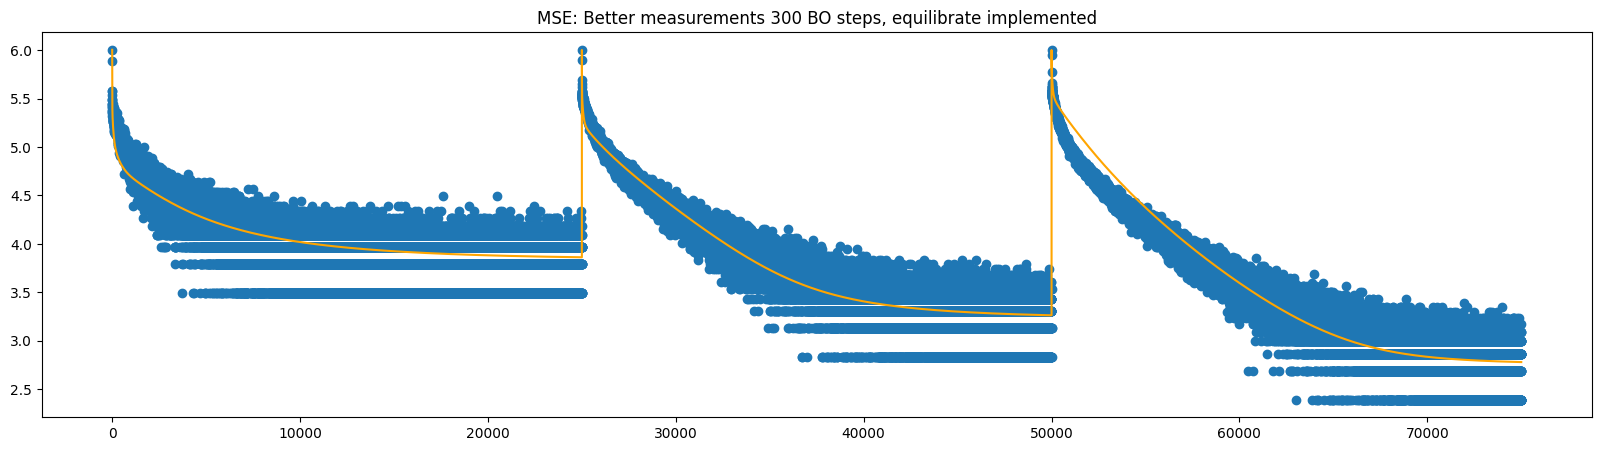

In [91]:
fig, ax = plt.subplots(1,1, figsize = (20,5))

output_after = trPL_agent.TRPL_function(times_data2, mo_newAfter.params, take_Log = True, Gs = np.array(trPLs_after.powers)/trPLs_after.powers[0], constant_floor_normalised_raw=noises2, reprates = trPLs_after.reprates_Hz, N_x = 20, equilibrate=True)

plt.scatter(np.arange(len(times_data2)), logdatas2)
plt.plot(np.arange(len(times_data2)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")

print("MSE = "+str(np.mean(np.square((logdatas2 - output_after)))))

MSE = 0.040179689662394096


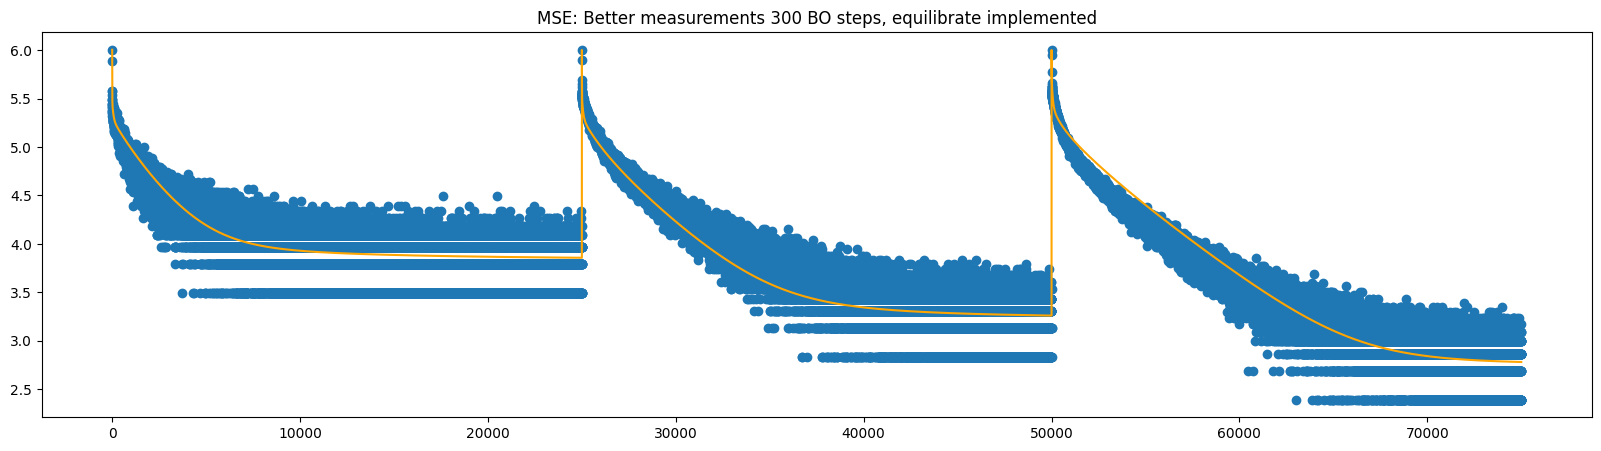

In [52]:
fig, ax = plt.subplots(1,1, figsize = (20,5))

output_after = trPL_agent.TRPL_function(times_data2, mo_newAfter.params, take_Log = True, Gs = np.array(trPLs_after.powers)/trPLs_after.powers[0], constant_floor_normalised_raw=noises2, reprates = trPLs_after.reprates_Hz, N_x = 20, equilibrate=True)

plt.scatter(np.arange(len(times_data2)), logdatas2)
plt.plot(np.arange(len(times_data2)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")

print("MSE = "+str(np.mean(np.square((logdatas2 - output_after)))))

In [17]:
bestFit_after.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=8.432338465484061e+20, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=5.950477554035936e+20, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=3.511195438827898e+20, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=1.8920271589132276e-15, relRange=1, lims=[1e-20, 1e-10], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log)

In [89]:
gradient_mo10.params

[Fitparam(name=kdirect, val=9.371906466121491e-18, relRange=1, lims=[1e-18, 1e-16], std=1.0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=3.882422787054201e+21, relRange=0, lims=[1e+18, 1e+25], std=0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=2.7534659237324936e+21, relRange=0, lims=[1e+18, 1e+25], std=0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=1.3598235837906526e+19, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=1.1997419828095108e-16, relRange=0, lims=[1e-20, 1e-10], std=0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, 

MSE = 0.03458533255062845


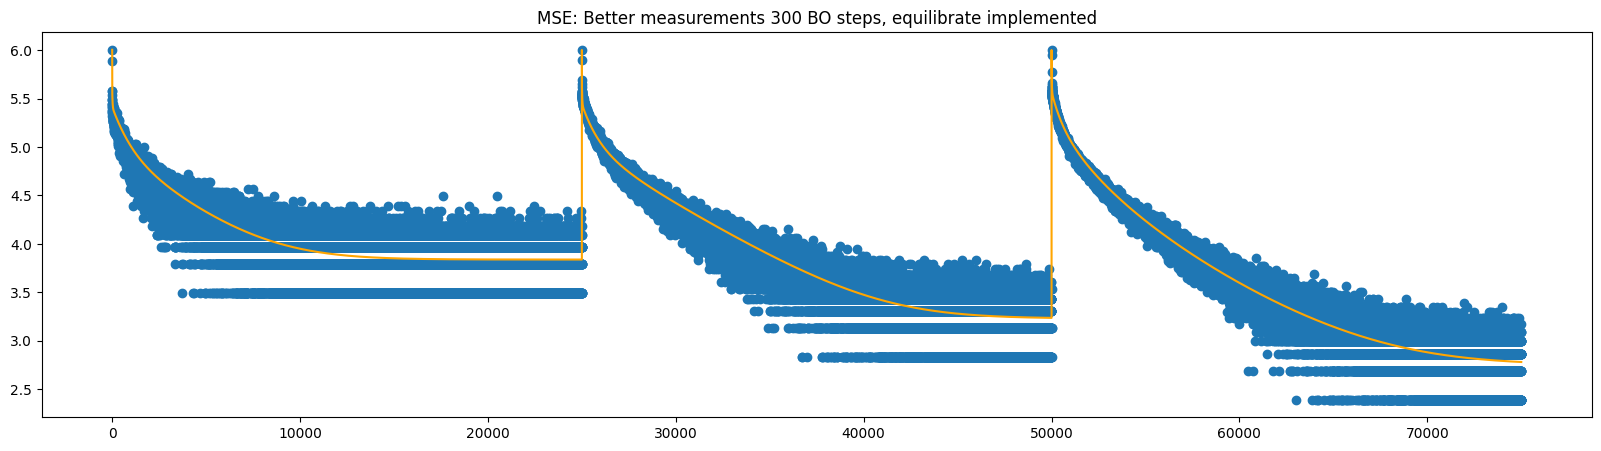

In [23]:
fig, ax = plt.subplots(1,1, figsize = (20,5))

output_after = trPL_agent.TRPL_function(times_data2, bestFit_after.params, take_Log = True, Gs = np.array(trPLs_after.powers)/trPLs_after.powers[0], constant_floor_normalised_raw=noises2, reprates = trPLs_after.reprates_Hz, N_x = 20, equilibrate=True)

plt.scatter(np.arange(len(times_data2)), logdatas2)
plt.plot(np.arange(len(times_data2)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")

print("MSE = "+str(np.mean(np.square((logdatas2 - output_after)))))

In [53]:
mo_newAfter.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=2.5168772063504396e+23, relRange=0, lims=[1e+18, 1e+25], std=0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=9.858966203921267e+21, relRange=0, lims=[1e+18, 1e+25], std=0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=4.263803859481448e+24, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=2.6663644384694053e-15, relRange=0, lims=[1e-20, 1e-10], std=0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fi

In [53]:
gradient_mo10 = deepcopy(mo_newAfter) # get the best parameters

for p, pBO in zip(gradient_mo10.params,mo_newAfter.params):
    p.val = pBO.val
    p.startVal = pBO.val # reset the start values to the best ones before starting the gradient descent
    p.relRange = 1

    if(p.name == 'kdirect'):
        p.relRange = 0

    if(p.name == 'N0_gen'):
        p.relRange = 0

    if(p.name == 'alpha'):
        p.relRange = 0

    if(p.name == 'L'):
        p.relRange = 0

    if(p.name == 'N0'):
        p.relRange = 0

    if(p.name == 'Eg'):
        p.relRange = 0
    
    if(p.name == 'Nc'):
        p.relRange = 0
    
    if(p.name == 'Nv'):
        p.relRange = 0

    if(p.name == 'Bp3'):
        p.lims = [1e-23, 1e-12]

    if(p.name == 'ETrap3'):
        p.lims = [0.8, 1.552]

kwargs_curve =  {'ftol':1e-11, 'xtol':1e-11, 'gtol': 1e-11, 'diff_step':0.00001,'loss':'linear','maxfev':100000}

print('Start curve fit')
try:
    rc = gradient_mo10.optimize_curvefit(kwargs=kwargs_curve) # fit the best parameters to the data
except Exception as e:
    print(e)
    print('Curve fit did not find a better solution')

Start curve fit
[np.float64(23.07390175887165), np.float64(21.13517440047234), np.float64(20.57580787903958), np.float64(-14.372448287626645), np.float64(-12.762981252984517), np.float64(-13.998312497083873), np.float64(-18.05296526037702), np.float64(-15.944142422174936), np.float64(-19.517411402954085), np.float64(0.2000274614703775), np.float64(1.3393846112411676), np.float64(1.153)]
lb = [np.float64(18.0), np.float64(18.0), np.float64(18.0), np.float64(-20.0), np.float64(-16.0), np.float64(-16.0), np.float64(-20.0), np.float64(-30.0), np.float64(-23.0), 0.2, 1.153, np.float64(0.8)][np.float64(25.0), np.float64(25.0), np.float64(25.0), np.float64(-10.0), np.float64(-6.0), np.float64(-6.0), np.float64(-10.0), np.float64(-15.0), np.float64(-12.0), 1.353, 1.552, np.float64(1.552)]


In [62]:
gradient_mo10.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=2.616416872673785e+23, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=7.89721707037196e+21, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=9.450250529513417e+21, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=4.285018886037487e-13, relRange=1, lims=[1e-20, 1e-10], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),


MSE = 0.03234288208653953


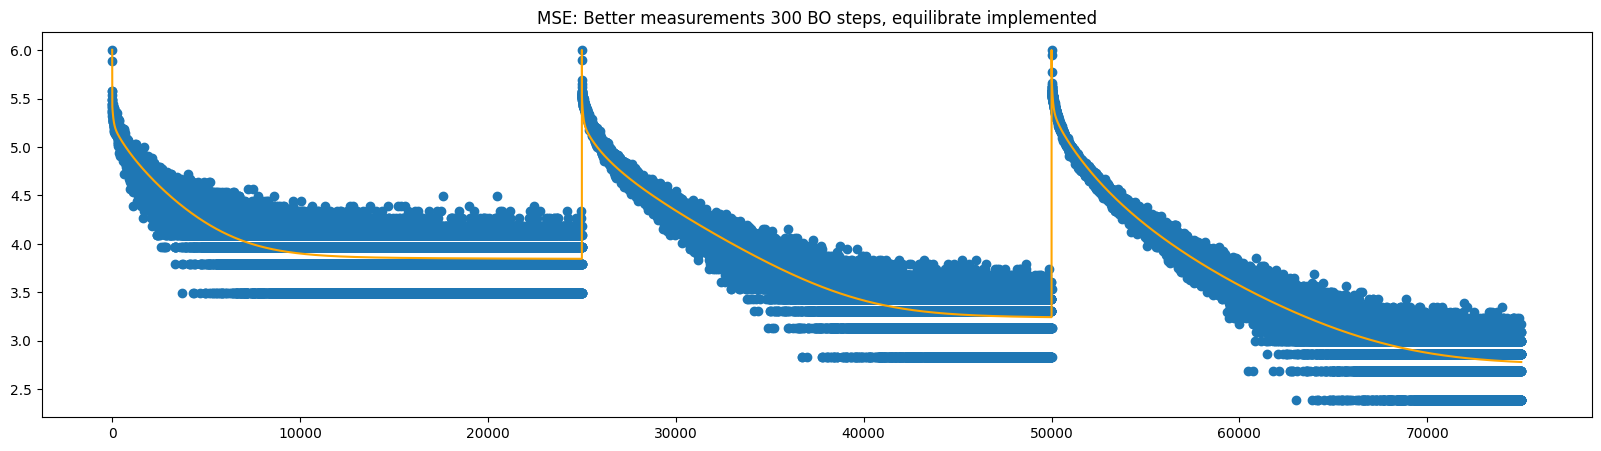

In [93]:
fig, ax = plt.subplots(1,1, figsize = (20,5))

output_after = trPL_agent.TRPL_function(times_data2, gradient_mo10.params, take_Log = True, Gs = np.array(trPLs_after.powers)/trPLs_after.powers[0], constant_floor_normalised_raw=noises2, reprates = trPLs_after.reprates_Hz, N_x = 20, equilibrate=True)

plt.scatter(np.arange(len(times_data2)), logdatas2)
plt.plot(np.arange(len(times_data2)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")

print("MSE = "+str(np.mean(np.square((logdatas2 - output_after)))))

MSE = 0.03235369590513849


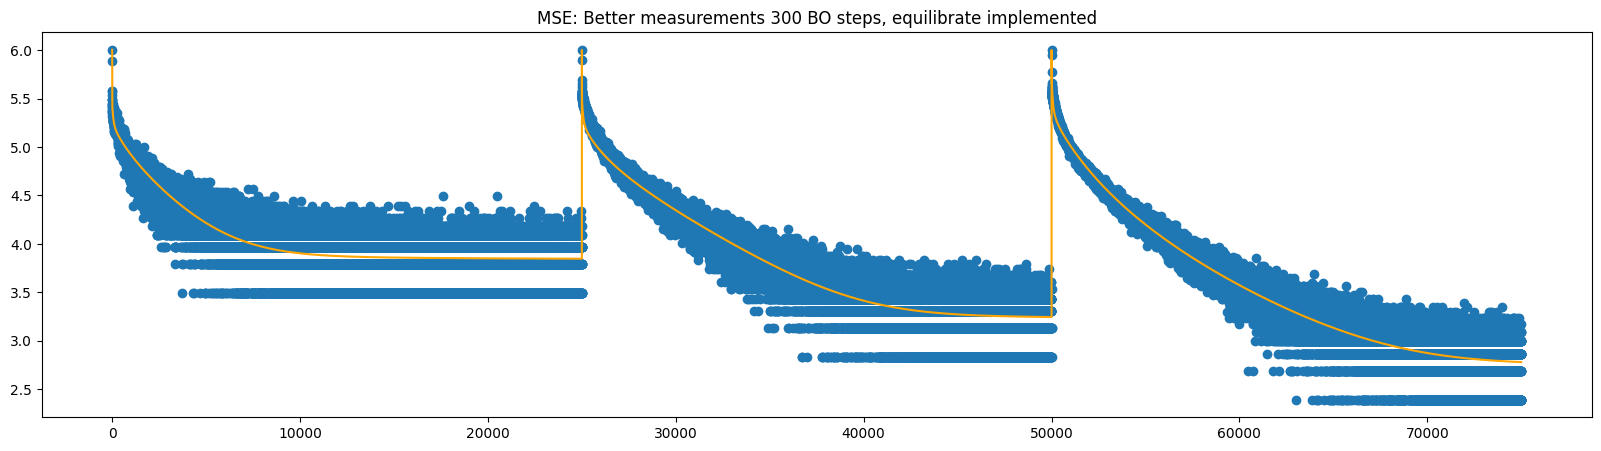

In [54]:
fig, ax = plt.subplots(1,1, figsize = (20,5))

output_after = trPL_agent.TRPL_function(times_data2, gradient_mo10.params, take_Log = True, Gs = np.array(trPLs_after.powers)/trPLs_after.powers[0], constant_floor_normalised_raw=noises2, reprates = trPLs_after.reprates_Hz, N_x = 20, equilibrate=True)

plt.scatter(np.arange(len(times_data2)), logdatas2)
plt.plot(np.arange(len(times_data2)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")

print("MSE = "+str(np.mean(np.square((logdatas2 - output_after)))))

In [55]:
import pickle
# with open(r'/media/qrb/0726-A615/Computer2CONTENTS/Simulations-Chapter1-Bis/LPtrPLFAPI/250522-Gradient-optimisedAfter-SecondRound.pickle', 'wb') as handle:
#     pickle.dump(gradient_mo10, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(r'./FittingResults/250526-Gradient-optimisedAfter-SecondRound.pickle', 'wb') as handle:
#     pickle.dump(gradient_mo10, handle, protocol=pickle.HIGHEST_PROTOCOL)